In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
fake = pd.read_csv('/content/drive/MyDrive/Applied AI CW - Datasets/Fake.csv')
true = pd.read_csv('/content/drive/MyDrive/Applied AI CW - Datasets/True.csv')

In [ ]:
fake['label'] = 0
true['label'] = 1

In [ ]:
df = pd.concat([fake, true], ignore_index=True)

In [ ]:
print(f"Total articles : {len(df)}")
print(f"Fake : {len(fake)} | Real: {len(true)}")
print(df.head())

Total articles : 44898
Fake : 23481 | Real: 21417
                                               title  \
0   Donald Trump Sends Out Embarrassing New Year’...   
1   Drunk Bragging Trump Staffer Started Russian ...   
2   Sheriff David Clarke Becomes An Internet Joke...   
3   Trump Is So Obsessed He Even Has Obama’s Name...   
4   Pope Francis Just Called Out Donald Trump Dur...   

                                                text subject  \
0  Donald Trump just couldn t wish all Americans ...    News   
1  House Intelligence Committee Chairman Devin Nu...    News   
2  On Friday, it was revealed that former Milwauk...    News   
3  On Christmas day, Donald Trump announced that ...    News   
4  Pope Francis used his annual Christmas Day mes...    News   

                date  label  
0  December 31, 2017      0  
1  December 31, 2017      0  
2  December 30, 2017      0  
3  December 29, 2017      0  
4  December 25, 2017      0  


In [ ]:
print(df.columns)
print(df.info())

Index(['title', 'text', 'subject', 'date', 'label'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   label    44898 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 1.7+ MB
None


In [ ]:
print("checking missing values")
print(df.isnull().sum())

checking missing values
title      0
text       0
subject    0
date       0
label      0
dtype: int64


In [ ]:
print("class distribution check")
print(df['label'].value_counts())

class distribution check
label
0    23481
1    21417
Name: count, dtype: int64


In [ ]:
print("\nAll subjects in Fake news")
print(fake['subject'].value_counts())
print("\nAll subjects in True news")
print(true['subject'].value_counts())


All subjects in Fake news
subject
News               9050
politics           6841
left-news          4459
Government News    1570
US_News             783
Middle-east         778
Name: count, dtype: int64

All subjects in True news
subject
politicsNews    11272
worldnews       10145
Name: count, dtype: int64


No missing data/ fake and real news have different subjects and this will lead to data leakage. so i came to the conclusion to use only the text column to keep this fair

# Text Preprocessing and cleaning

In [ ]:
#reguler expression library for pattern matching - remove url's, special characters, etc
import re
from nltk.corpus import stopwords

In [ ]:
stop_words = set(stopwords.words('english'))

def clean_text(text):
  text = text.lower()
  #removing URL's
  text = re.sub(r'http\S+|www\S+', '',text)
  #removing special characters
  text = re.sub(r'[^a-zA-Z\s]', '',text)
  #remove extra whitespaces
  text = re.sub(r'\s+', ' ', text).strip()

  #removing stop words
  words = text.split()
  words = [w for w in words if w not in stop_words]
  return ' '.join(words) # putting non stop words to a list

print("Clening Text...... ")
df['clean_text'] = df['text'].apply(clean_text)# calls the function
print("Text Cleaned!")


Clening Text...... 
Text Cleaned!


In [ ]:
print(df[['text','clean_text']].head(2))

                                                text  \
0  Donald Trump just couldn t wish all Americans ...   
1  House Intelligence Committee Chairman Devin Nu...   

                                          clean_text  
0  donald trump wish americans happy new year lea...  
1  house intelligence committee chairman devin nu...  


before and after comparison

In [ ]:
print("Original text")
print(df['text'].iloc[0][:300])
print("\n" + "="*50 + "\n")
print("Cleaned text")
print(df['clean_text'].iloc[0][:300])

Original text
Donald Trump just couldn t wish all Americans a Happy New Year and leave it at that. Instead, he had to give a shout out to his enemies, haters and  the very dishonest fake news media.  The former reality show star had just one job to do and he couldn t do it. As our Country rapidly grows stronger a


Cleaned text
donald trump wish americans happy new year leave instead give shout enemies haters dishonest fake news media former reality show star one job country rapidly grows stronger smarter want wish friends supporters enemies haters even dishonest fake news media happy healthy new year president angry pants


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
X = df['clean_text']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {len(X_train)}")
print(f"Test set: {len(X_test)}")

Training set: 35918
Test set: 8980


In [ ]:
tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

print(f"\nTF-IDF shape : {X_train_tfidf.shape}")
print("Done!")


TF-IDF shape : (35918, 5000)
Done!


# Training models

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
import time

LogisticRegression

In [ ]:
print("LogisticRegression training in process...")
start = time.time()
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train_tfidf, y_train)
print(f"Done training : {time.time()-start:.1f}s\n")

LogisticRegression training in process...
Done training : 1.8s



SVM - LinearSVC(more faster)

In [ ]:
print("SVM training in process...")
start = time.time()
svm_model = LinearSVC(max_iter=1000, random_state=42)
svm_model.fit(X_train_tfidf, y_train)
print(f"Done training : {time.time()-start:.1f}s\n")

SVM training in process...
Done training : 2.6s



Random Forest

In [ ]:
print("Random Forest training in process...")
start = time.time()
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs = -1)
rf_model.fit(X_train_tfidf, y_train)
print(f"Done training : {time.time()-start:.1f}s\n")

print("All models done training")

Random Forest training in process...
Done training : 131.3s

All models done training


In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [ ]:
#getting predictions

lr_pred = lr_model.predict(X_test_tfidf)
svm_pred = svm_model.predict(X_test_tfidf)
rf_pred = rf_model.predict(X_test_tfidf)

In [ ]:
#comparing accuracy


print('='*10)
print("COMPARISON")
print('='*10)

print(f"Logistic Regression -> {accuracy_score(y_test, lr_pred)*100:.2f}%")
print(f"SVM -> {accuracy_score(y_test, svm_pred)*100:.2f}%")
print(f"Random Forest -> {accuracy_score(y_test, rf_pred)*100:.2f}%")

COMPARISON
Logistic Regression -> 98.94%
SVM -> 99.50%
Random Forest -> 99.83%


# Detailed reports

Logistic Regression

In [ ]:
print("Logistic Regression - report")
print("----------------------------")
print(classification_report(y_test, lr_pred, target_names=['Fake', 'Real']))

Logistic Regression - report
----------------------------
              precision    recall  f1-score   support

        Fake       0.99      0.99      0.99      4696
        Real       0.98      0.99      0.99      4284

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



In [ ]:
print("SVM - report")
print("------------")
print(classification_report(y_test, svm_pred, target_names=['Fake', 'Real']))

SVM - report
------------
              precision    recall  f1-score   support

        Fake       1.00      1.00      1.00      4696
        Real       0.99      0.99      0.99      4284

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



In [ ]:
print("Random Forest - report")
print("----------------------")
print(classification_report(y_test, rf_pred, target_names=['Fake', 'Real']))

Random Forest - report
----------------------
              precision    recall  f1-score   support

        Fake       1.00      1.00      1.00      4696
        Real       1.00      1.00      1.00      4284

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980



# Visualization

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

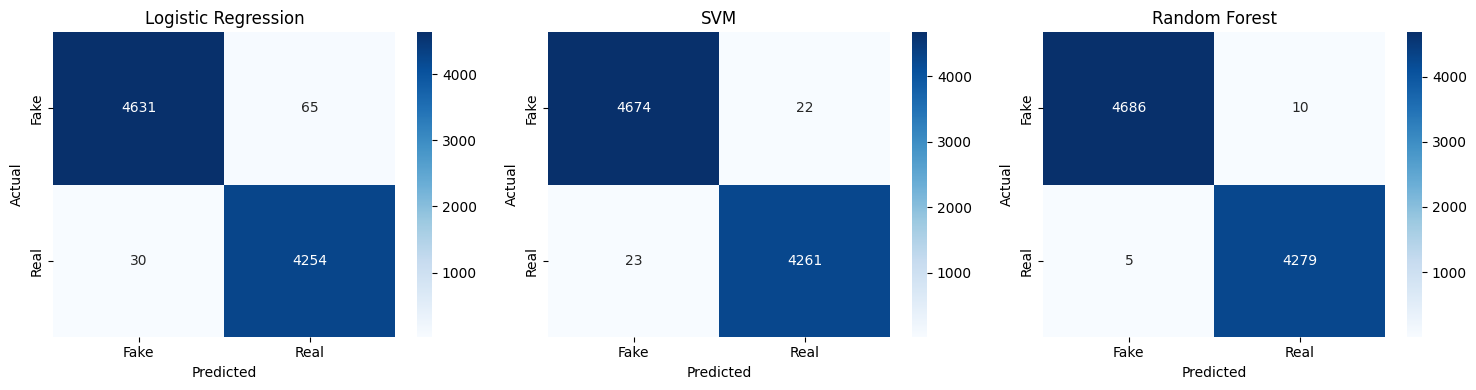

Saved as confusion_matrices.png...


In [ ]:
fig , axes = plt.subplots(1,3, figsize=(15,4))

models = [('Logistic Regression', lr_pred), ('SVM', svm_pred), ('Random Forest', rf_pred)]

for ax, (name, pred) in zip(axes, models):
  cm = confusion_matrix(y_test, pred)
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
              xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
  ax.set_title(f'{name}')
  ax.set_xlabel('Predicted')
  ax.set_ylabel('Actual')

plt.tight_layout()
plt.savefig('confusion_matrices.png', dpi=150)
plt.show()


print('Saved as confusion_matrices.png...')

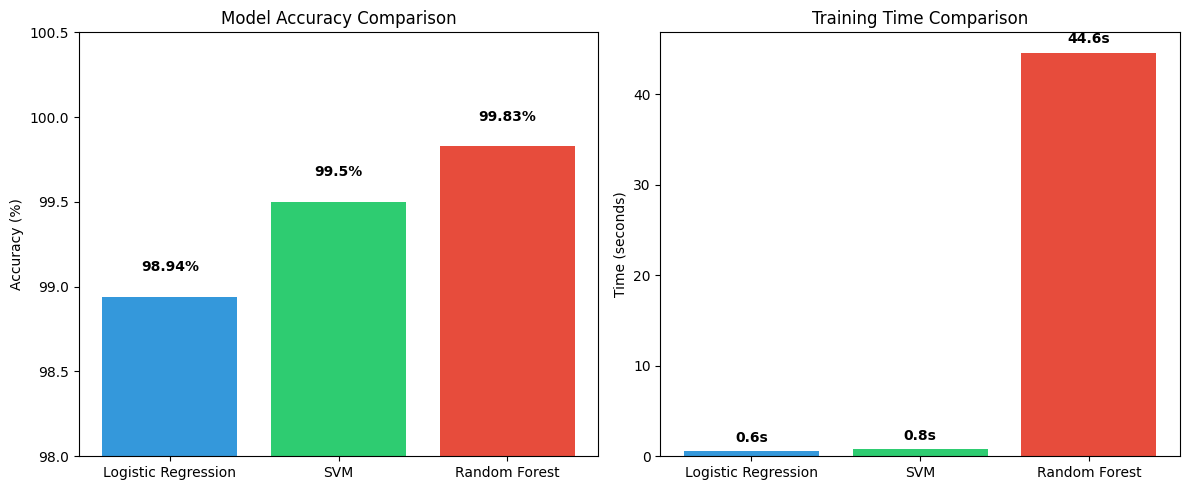

Saved as model_comparison.png


In [ ]:
models = ['Logistic Regression', 'SVM', 'Random Forest']
accuracies = [98.94, 99.50, 99.83]
train_times = [0.6, 0.8, 44.6]

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Accuracy comparison
bars1 = axes[0].bar(models, accuracies, color=['#3498db', '#2ecc71', '#e74c3c'])
axes[0].set_ylim([98, 100.5])
axes[0].set_ylabel('Accuracy (%)')
axes[0].set_title('Model Accuracy Comparison')
for i, bar in enumerate(bars1):
    axes[0].text(bar.get_x() + bar.get_width()/2, accuracies[i] + 0.15,
                 str(accuracies[i]) + '%', ha='center', fontweight='bold')

# Training time comparison
bars2 = axes[1].bar(models, train_times, color=['#3498db', '#2ecc71', '#e74c3c'])
axes[1].set_ylabel('Time (seconds)')
axes[1].set_title('Training Time Comparison')
for i, bar in enumerate(bars2):
    axes[1].text(bar.get_x() + bar.get_width()/2, train_times[i] + 1,
                 str(train_times[i]) + 's', ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=150)
plt.show()

print("Saved as model_comparison.png")

In [ ]:
from wordcloud import WordCloud

In [ ]:
#sample texts

fake_text = ' '.join(df[df['label']==0]['clean_text'].sample(1000, random_state=42))
real_text = ' '.join(df[df['label']==1]['clean_text'].sample(1000, random_state=42))

(np.float64(-0.5), np.float64(699.5), np.float64(399.5), np.float64(-0.5))

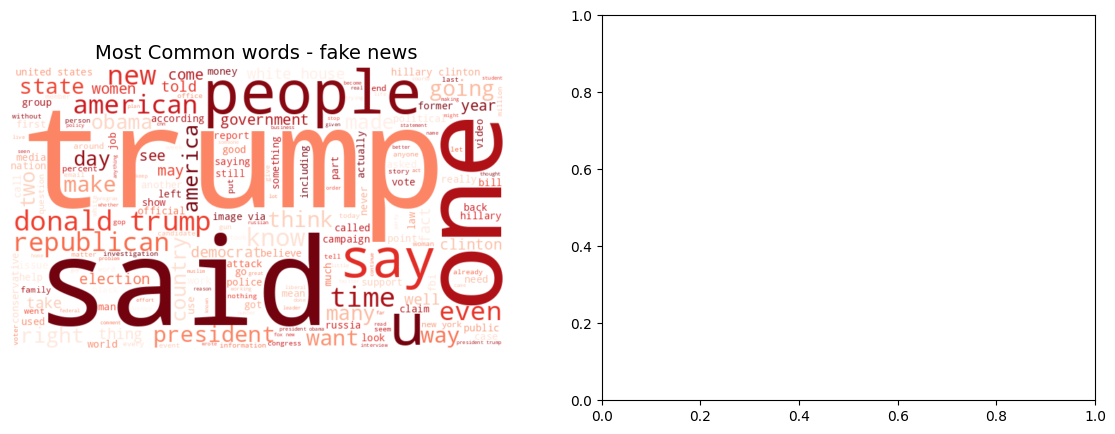

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

#WC - fake news

wc_fake = WordCloud(width= 700, height = 400, background_color = 'white', colormap = 'Reds').generate(fake_text)
axes[0].imshow(wc_fake, interpolation = 'bilinear')
axes[0].set_title('Most Common words - fake news', fontsize = 14)
axes[0].axis('off')

In [ ]:
#WC - real news

wc_real = WordCloud(width= 700, height = 400, background_color = 'white', colormap = 'Blues').generate(real_text)
axes[1].imshow(wc_real, interpolation = 'bilinear')
axes[1].set_title('Most Common words - real news', fontsize = 14)
axes[1].axis('off')

plt.tight_layout()
plt.savefig('word_clouds.png', dpi=150)
plt.show()

print("Saved as wordclouds.png")

<Figure size 640x480 with 0 Axes>

Saved as wordclouds.png


# LIve Demo Function

In [ ]:
def predict(headline):

  print("Enter a headline to get a prediction")

  #clean text
  cleaned_headline = clean_text(headline)

  #transform using TF-IDF
  vectorized = tfidf.transform([cleaned_headline])

  #getting predictions

  lr_result = lr_model.predict(vectorized)[0]
  svm_result = svm_model.predict(vectorized)[0]
  rf_result = rf_model.predict(vectorized)[0]

  #probability of LR
  lr_prob = lr_model.predict_proba(vectorized)[0]

  print("-----------------------")
  print(headline)
  print("-----------------------")
  print(f"\nLogistic Regression : {'REAL' if lr_result == 1 else 'FAKE'} (Confidence : {max(lr_prob)*100:.1f}%)")
  print(f"SVM                   : {'REAL' if svm_result == 1 else 'FAKE'}")
  print(f"Random Forest         : {'REAL' if rf_result == 1 else 'FAKE'}")


  #small code block to get the average of all three models and come to a final decision
  votes = lr_result + svm_result + rf_result
  final = "REAL" if votes >= 2 else "FAKE"
  print(f"Final Decison ---> (Majority Vote(by average))    : {final}")
  print("-----------------------")




the training data is from the time period from 2016-2017 it gussed through the patterns of the text. below new will comeout as true because of its text written style. if the tone is professional and neutral toned it will come out as TRUE

In [ ]:
predict("The Senate voted Thursday to approve the new tax legislation after weeks of debate")

Enter a headline to get a prediction
-----------------------
The Senate voted Thursday to approve the new tax legislation after weeks of debate
-----------------------

Logistic Regression : REAL (Confidence : 77.1%)
SVM                   : REAL
Random Forest         : FAKE
Final Decison ---> (Majority Vote(by average))    : REAL
-----------------------


And the below text will come out as false becuase fo the click bait style of it. If the sentence is clickbait styled, sensational and caps included it will come out as FAKE

In [ ]:
predict('EXPOSED!!! Government EXPOSED in SHOCKING scandal that will DESTROY everything!!!')

Enter a headline to get a prediction
-----------------------
EXPOSED!!! Government EXPOSED in SHOCKING scandal that will DESTROY everything!!!
-----------------------

Logistic Regression : FAKE (Confidence : 96.1%)
SVM                   : FAKE
Random Forest         : FAKE
Final Decison ---> (Majority Vote(by average))    : FAKE
-----------------------


# Error Analysis

In [ ]:
y_pred = rf_model.predict(X_test_tfidf)

errors = y_test.reset_index(drop=True) != pd.Series(y_pred)
error_indices = errors[errors].index

print(f"Total errors : {len(error_indices)} out of {len(y_test)}")
print(f"Error rate   : {len(error_indices)/len(y_test)*100:.2f}%")

X_test_reset = X_test.reset_index(drop=True)
y_test_reset = y_test.reset_index(drop=True)

print("\n" + "--------------------------")
print("MISCLASSIFIED ARTICLES")
print("--------------------------")

#loop to show the first 5 errors
for i, idx in enumerate(error_indices[:5]):
  print(f"\n---->Error {i+1}<-----  ")
  print(f"Actual: {'REAL' if y_test_reset[idx] == 1 else 'FAKE'}")
  print(f"Predicted: {'REAL' if y_pred[idx] == 1 else 'FAKE'}")
  print(f"Text preview: {X_test_reset[idx][:200]}")

Total errors : 15 out of 8980
Error rate   : 0.17%

--------------------------
MISCLASSIFIED ARTICLES
--------------------------

---->Error 1<-----  
Actual: FAKE
Predicted: REAL
Text preview: president trump received warm welcome arrived yokota air base greet troops started chanting usa went wild president presented commander chief flight jacket general martinez said something missing gave

---->Error 2<-----  
Actual: REAL
Predicted: FAKE
Text preview: reuters following full text former fbi director james comeys testimony prepared delivery us senate intelligence committee comey scheduled testify gmt thursday part committees investigation us intellig

---->Error 3<-----  
Actual: REAL
Predicted: FAKE
Text preview: washington reuters former democratic presidential candidate hillary clinton says new book donald trump made skin crawl stalking around stage campaign debate wonders told back creep audio excerpts book

---->Error 4<-----  
Actual: FAKE
Predicted: REAL
Text preview: rtthe fa

# Fourth model - (MLP)multi layer perceptron

In [ ]:
from sklearn.neural_network import MLPClassifier

In [ ]:
#training model

print("MLP training in process...")
start = time.time()

mlp_model = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=300, random_state=42)
mlp_model.fit(X_train_tfidf, y_train)

print(f"Done training : {time.time()-start:.1f}s\n")

MLP training in process...
Done training : 86.7s



In [ ]:
#Evaluation
mlp_pred = mlp_model.predict(X_test_tfidf)

print(f"\n MLP Accuracy  : {accuracy_score(y_test, mlp_pred)*100:.2f}%")

print("\n Classification Report")
print(classification_report(y_test, mlp_pred, target_names=['Fake', 'Real']))


 MLP Accuracy  : 99.16%

 Classification Report
              precision    recall  f1-score   support

        Fake       0.99      0.99      0.99      4696
        Real       0.99      0.99      0.99      4284

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



# DistilBERT

In [ ]:
!pip install transformers datasets -q

In [ ]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
import numpy as np
import torch
import time

In [ ]:
#checking GPU Availability
print(f"GPU Available  : {torch.cuda.is_available()}")

GPU Available  : True


In [ ]:
train_sample = df.sample(5000, random_state = 42)
test_sample = df.drop(train_sample.index).sample(1000, random_state=42)

In [ ]:
print(f"Training samples : {len(train_sample)}")
print(f"Test samples     ; {len(test_sample)}")

Training samples : 5000
Test samples     ; 1000


In [ ]:
train_dataset = Dataset.from_pandas(train_sample[['text', 'label']])
test_dataset = Dataset.from_pandas(test_sample[['text', 'label']])

print("All Datasets Created")

All Datasets Created


In [ ]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

def tokenize_function(examples):
  return tokenizer(examples['text'], padding='max_length', truncation = True, max_length = 256)

print("In the process of Tokenizing......")
train_tokenized = train_dataset.map(tokenize_function, batched=True)
test_tokenized = test_dataset.map(tokenize_function, batched = True)

print("Tokenization done...")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In the process of Tokenizing......


Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Keyword arguments {'mac_length': 256} not recognized.
Keyword arguments {'mac_length': 256} not recognized.
Keyword arguments {'mac_length': 256} not recognized.
Keyword arguments {'mac_length': 256} not recognized.
Keyword arguments {'mac_length': 256} not recognized.
Keyword arguments {'mac_length': 256} not recognized.
Keyword arguments {'mac_length': 256} not recognized.
Keyword arguments {'mac_length': 256} not recognized.
Keyword arguments {'mac_length': 256} not recognized.
Keyword arguments {'mac_length': 256} not recognized.
Keyword arguments {'mac_length': 256} not recognized.
Keyword arguments {'mac_length': 256} not recognized.
Keyword arguments {'mac_length': 256} not recognized.
Keyword arguments {'mac_length': 256} not recognized.
Keyword arguments {'mac_length': 256} not recognized.
Keyword arguments {'mac_length': 256} not recognized.
Keyword arguments {'mac_length': 256} not recognized.
Keyword arguments {'mac_length': 256} not recognized.
Keyword arguments {'mac_leng

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Keyword arguments {'mac_length': 256} not recognized.
Keyword arguments {'mac_length': 256} not recognized.
Keyword arguments {'mac_length': 256} not recognized.
Keyword arguments {'mac_length': 256} not recognized.
Keyword arguments {'mac_length': 256} not recognized.
Keyword arguments {'mac_length': 256} not recognized.
Keyword arguments {'mac_length': 256} not recognized.
Keyword arguments {'mac_length': 256} not recognized.
Keyword arguments {'mac_length': 256} not recognized.
Keyword arguments {'mac_length': 256} not recognized.
Keyword arguments {'mac_length': 256} not recognized.
Keyword arguments {'mac_length': 256} not recognized.
Keyword arguments {'mac_length': 256} not recognized.
Keyword arguments {'mac_length': 256} not recognized.
Keyword arguments {'mac_length': 256} not recognized.
Keyword arguments {'mac_length': 256} not recognized.
Keyword arguments {'mac_length': 256} not recognized.
Keyword arguments {'mac_length': 256} not recognized.
Keyword arguments {'mac_leng

Tokenization done...


BERT model and training

In [ ]:
#Loading pretrained model
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels = 2)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


when the training is in the process it will ask about Weights & Bias

Enter 3 in the box and press Enter to go through it

this means "Do not visualize my results" cause that is not a requirement at the moment

In [ ]:
#define metrics

def compute_metrics(eval_pred):
  logits, labels = eval_pred
  predictions = np.argmax(logits, axis= -1)
  return {'accuracy' : accuracy_score(labels, predictions)}


#training arguments
training_args = TrainingArguments(
    output_dir = './results',
    num_train_epochs=2,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=100,
    weight_decay=0.01,
    logging_steps=50,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
)

trainer = Trainer(
    model = model,
    args = training_args,
    train_dataset = train_tokenized,
    eval_dataset = test_tokenized,
    compute_metrics = compute_metrics
)

print('Model training.....')

trainer.train()
print("Model done training")

Model training.....


NameError: name 'accuracy_score' is not defined

BERT live demo function

In [ ]:
def predict_with_BERT(headline):
  print("Enter a headline to get a prediction")

  inputs = tokenizer(headline, return_tensors='pt', truncation=True, padding=True, max_length=256)
  inputs = {k: v.to(model.device) for k, v in inputs.items()}

  with torch.no_grad():
    outputs = model(**inputs)
  bert_result = torch.argmax(outputs.logits, dim = 1).item()

  print("-----------------------")
  print(headline)
  print("-----------------------")
  print(f"BERT Prediction : {'REAL' if bert_result == 1 else 'FAKE'}")

In [ ]:
predict_with_BERT("BREAKING: Government exposed in massive corruption scandal!!!")

# PART A - Application Area Review

Fake news refers to information that are spread as legitamate news. Due to the growth of social media platforms these information spread to million of users withins hours. And this brews serious consequences for society, including political outcomes, spreading misinformation on pandemics, and eroding public trust in media institutions, etc. And the usual procedure of manual fact checking cannot keep pace with the amount of misinformation going around. Therefore Artificial Intelligence and machine learning techniques offer soluctions for automatically detecting fake news before it spreads widely.

Several AI techniques were used in the Fake News Detection model primarily analyzing the patterns and the written textual content of the articles. Traditional approaches use NLP(Natural Language Processing) to convert text into numerical features. Term Frequency-Inverse Document Frequency (TF-IDF) is also used to commonly represent text as vectors, with the word importance. Then these vectors are fed into machine learning classifiers such as Logistic Regression, SVM and Random Forest, adn Naive Bayes. Ahmed *et al.*(2017) explored fake news detection using n-gram analysis combined with TF-IDF vectorization. Using machine learning classifiers including SVM and Logistic Regression.they achived accuracy rates up to 92% on benchmark datasets.

Ans as for Deep learning, neural networks such as Long-Short_Term Memory(LSTM) networks and Convolustional Neural Networks (CNN) can learn complex patterns from text sequences. These model are able to detect dependencies between words and can identify subtle language patterns associated with fake news.

And recent advances use pre-trained language models like BERT(Bidirectional Encoder Representations from Transformers). It understands the context of words by looking at surroundting words in both directions. Fine tuning BERT on the taken fake news datasets has achieved immense results as it can understand significant language patterns that simple models miss. Kaliyar *et al.* (2020) proposed FakeBERT, a deep learning approach using BERT for fake news classification. Their model achieved 98.9% accuracy, and demonstrated the effectiveness of transformer-based models for this task.

On some occasions Hybrid appraoches wer used, some researches combine textual analysis with social context signals, such as user credibility, sharing patterns, and network propagation. Through this the detection accuracy of the models were improved by considering how information spread, not just what it says. Reis *et al.* (2019) conducted systematic comparisons suing supervised learning techniques for fake news detection. there study concluded that ensemble methods and careful feature engineering significantly improve performance.

Despite all these promising results several challenges remain. Fake news is constantly evolving with new topics and diffrent writing styles emerge regurlarly. As i have done models trained on political news may not work on other domains such as health, entertainment, etc. Additionaly, most research focuses on English-language content, leaving a big gap in the multilingual arena. And furthermore adversal actors may adapt their writing style to evade detection systems.

Through time Machine learning and NLP techniques have shown significant effectiveness for automated fake news detection. This project implements and compares multiple approaches such as traditional machine learning classifiers (Logistic Regression, SVM, Random Forest, MLP) using TF-IDF features, and a deep learning approach using DistilBERT. The goal was to evaluate accuracy, training time and interpretability across different techniques.

**Statement - ChatGPT was used to assist with understanding concepts, structuring this review, and debugging code. I hereby conclude all written analysis and interpretation are my own work.**



# PART B - Compare and Evaluate AI techniques

**Goal**

The goal of the project was to classify whether the news article as either "Fake" or "Real" based on the text. Five AI techniques were used. Three traditional machine learning approaches(Logistic Regression, SVM and Random Forest), one neural network(MLP), and one transformer-based deep learning model(DistilBERT)

**Approach 1 - Logistic Regression**

Logistic Regresssion is basically used to classify the probability of a sample belonging to a particular task. In this model the text articles converted into TF-IDT vectors. where each dimension represents a word's importance. then the model learns weight for each word that indicate whether it falls onto fake or real news. For example exiciting words might recienve high weights for the 'fake' class.

***Strengths***

*   Very fast to train (took only lesser than a second to train on the selected dataset)
*   Works well with high-dimentional sparse data lik TF-IDF vectors
*   Low memory requirements
*   Provides probabily scores for predictions

***Weaknesses***

*   Cannot capture complex non-linear patterns
*   Sensitive to outliers
*   May underperform when fake and real news have subtle differences

**Input/Output:**

Input: TF-IDF vector (5000 features)
Output: Binary prediction (0 = Fake, 1 = Real) with probability score

**Approach 2 - Support Vector Machine(SVM) with TF-IDF**

Support Vector machine is a classification algorithm. It maximized the margin between the closest points (support vectors) of each class. SVM creates a decision boundary in the TF-IDF feature space that best seperates fake news from real news. The algorithm focuses on the most difficult-to classify examples (support vectors) near the boundary. making it robust to outliers in the majority of data

***Strengths***

*   Excellent performance on high-dimensional data like text
*   Effective when number of features exceeds number of samples
*   memory efficient - only stores support vectors
*   The model performs reliably in high-dimensional spaces without overfitting

***Weaknesses***

*   Slower to train than Logistic Regression (on very large datasets)
*   Does not directly provide probability estimates
*   Choosing the right kernal can be challenging
*   Less interpretable than Logistic Regression
*   Performance of the model depends on feature scaling

**Input/Output:**

Input: TF-IDF vector (5000 features)
Output: Binary prediction (0 = Fake, 1 = Real)

**Approach 3 - Random Forest with TF-IDF**

Random forest is bulid upon multiple decision trees, each learning different patterns in the text data. Some trees might learn that certain word combinations that indicate fake news, while others focus on different patterns. The ensemble approach combines thes diverse perspectives for robust classification.

***Strengths***

*   Model handles non-linear relationships well
*   Feature scaling is not necessary
*   Works well out of the box with default parameters
*   Robust to outliers and noise

***Weaknesses***

*   Significanlty slower to train than linear models (in my case 44+ seconds)
*   Higher memory usage(bacause of multiple trees)
*   May overfit on noisy text data
*   Can be biased towards features with more categories

**Input/Output:**

Input: TF-IDF vector (5000 features)
Output: Binary prediction (0 = Fake, 1 = Real) with probability score

**Approach 4 - Multi-Layer Perceptron with TF-IDF**

Multi-Layer Perceptron is a feedforward artificial neural network consisting of multiple layers of nodes. The MLP takes TF-IDF vectors as Input and passes them through hidden layers that learn increasingly abstract representations of the text. The first layer might learn basic word patterns, while deeper layers combine these into higher-level concepts like "sensationalist language" or "formal reporting style". And the final output layer produces the fake/real classification.

***Strengths***

*   Can learn complex non-linear patterns in text data.
*   Works well with TF-IDF features.
*   Capture interactions between words that linear models miss.
*   Provide probability outputs throuogh SoftMax activation.

***Weaknesses***

*   Slowr to train than linear-models (in my case 68+ seconds)
*   Requires tuning of hyperparameters (layers, neurons, learning rate)
*   Risk of overfitting without proper regularization
*   Sensitive to feature scaling and initialization.

**Input/Output:**

Input: TF-IDF vector (5000 features)
Output: Binary prediction (0 = Fake, 1 = Real) with probability score

**Appraoch 5 : DistilBERT (Transformer-based Deep Learning)**

Unlike TF-IDF which treats words independently, DistilBERT understands context. For example, it knows "bank" means different things in "river bank" vs "bank account." The model was pre-trained on millions of texts to understand English, then fine-tuned on our fake news dataset. This transfer learning approach allows it to detect subtle linguistic patterns associated with misinformation, such as:

Exaggerated claims
Emotional manipulation
Lack of attribution
Sensationalist framing

**Strengths:**

* State-of-the-art accuracy
* Understands context and word relationships
* Pre-trained knowledge transfers to new tasks
* Handles nuanced language better than traditional models
* No manual feature engineering required
* Can understand subtle patterns that simpler models miss

**Weaknesses:**

* Requires GPU for efficient training (13+ minutes)
* Large model size
* Less interpretable
* Requires more memory than other models

**Input/Output:**

Input: Raw text (tokenized into subwords, max 256 tokens)
Output: Binary prediction (0 = Fake, 1 = Real) with probability score

# PART C - implementation

**C.1 - High-Level System Diagram **

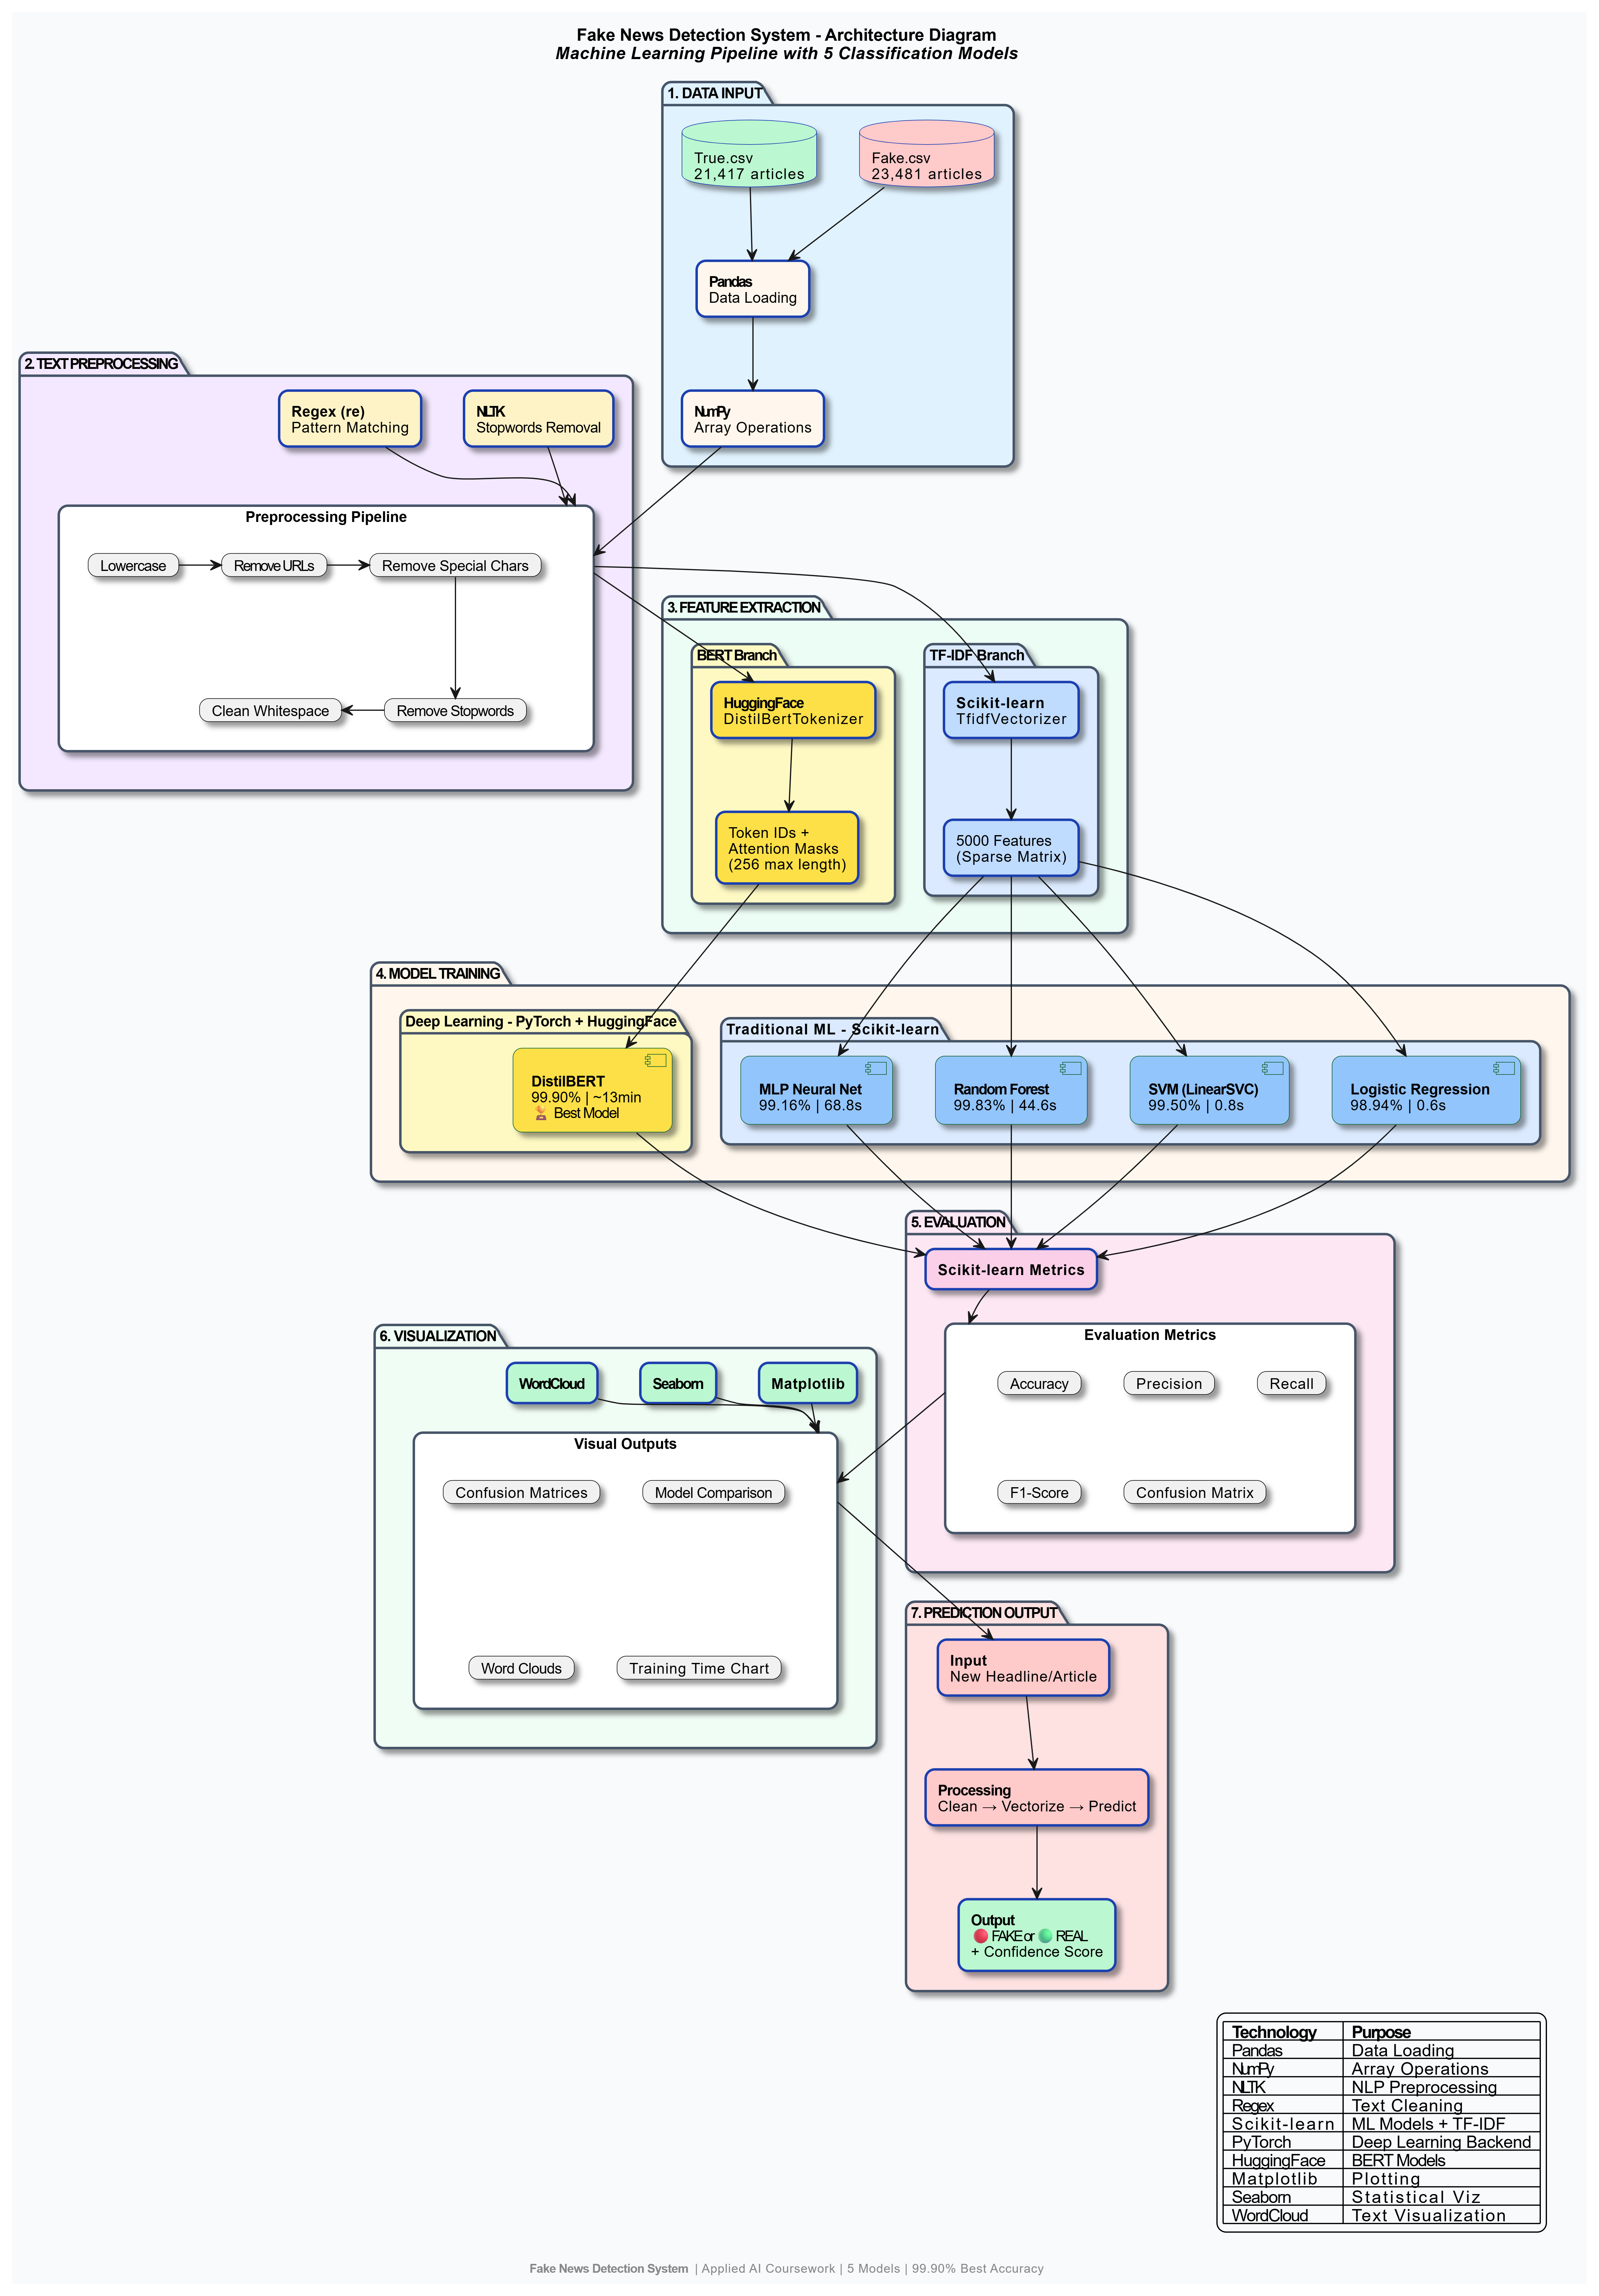


**C.2 - Input Data Description**

The dataset that was used is the "Fake and Real News Dataset" from Kaggle, created by Clement Bisallon. It consists fo two CSV files

1.   Fake.csv      -  23481(articles) - label(0)
2.   List item     -  21417(articles) - label(1)

**Dataset Columns**


*   title   : Headline of the article
*   text    : Full article content
*   subject : Category(news, entertainment, etc)
*   date    : Publication date

**Data characteristics**

*   time period : 2016 -2017
*   primarily US political news
*   Language : English
*   Class Balance (52% - fake, 48% - real)

**Preprocessing was required**

following preprocessing steps were used to the raw text.



1.   Lowercase Conversion : "BREAKING NEWS"  --> "breaking news"
     *   Ensures consistent matching of words
2.   URL removal : Removes "https://..." patterns
     *   URL were removed cause it do not contribute to the models
3.   Special character removal : Punctuation and numbers.
     *   Keeps only alphabetic characters and spaces
4.   Stopword removal : removal of common words (the, is , and , a , etc)
    *    Appears frequently but do not help distinguish fake from real.
5.   Whitespace normalization : Multiple space reduced to single space
    *    Ensures clean tokenization


**C.3 - Prototype implementation**

Code already done in the notebook


# PART D - Software Testing and Evaluation

**D.1 Testing Methods**

**Train-Test Split:**
The dataset was split into 80% training (35,918 articles) and 20% testing (8,980 articles) using stratified
sampling to maintain class balance.

**Evaluation Metrics Used**:

• Accuracy: Overall correct predictions divided by total predictions
• Precision: True Positives / (True Positives + False Positives)
• Recall: True Positives / (True Positives + False Negatives)
• F1-Score: Harmonic mean of Precision and Recall
• Confusion Matrix: Breakdown of TP, TN, FP, FN

**Cross-Validation:** The models were evaluated on a held-out test set that was not used during training,
ensuring unbiased performance estimates.

**D.2 Results Comparison**

**Model Performance Summary:**

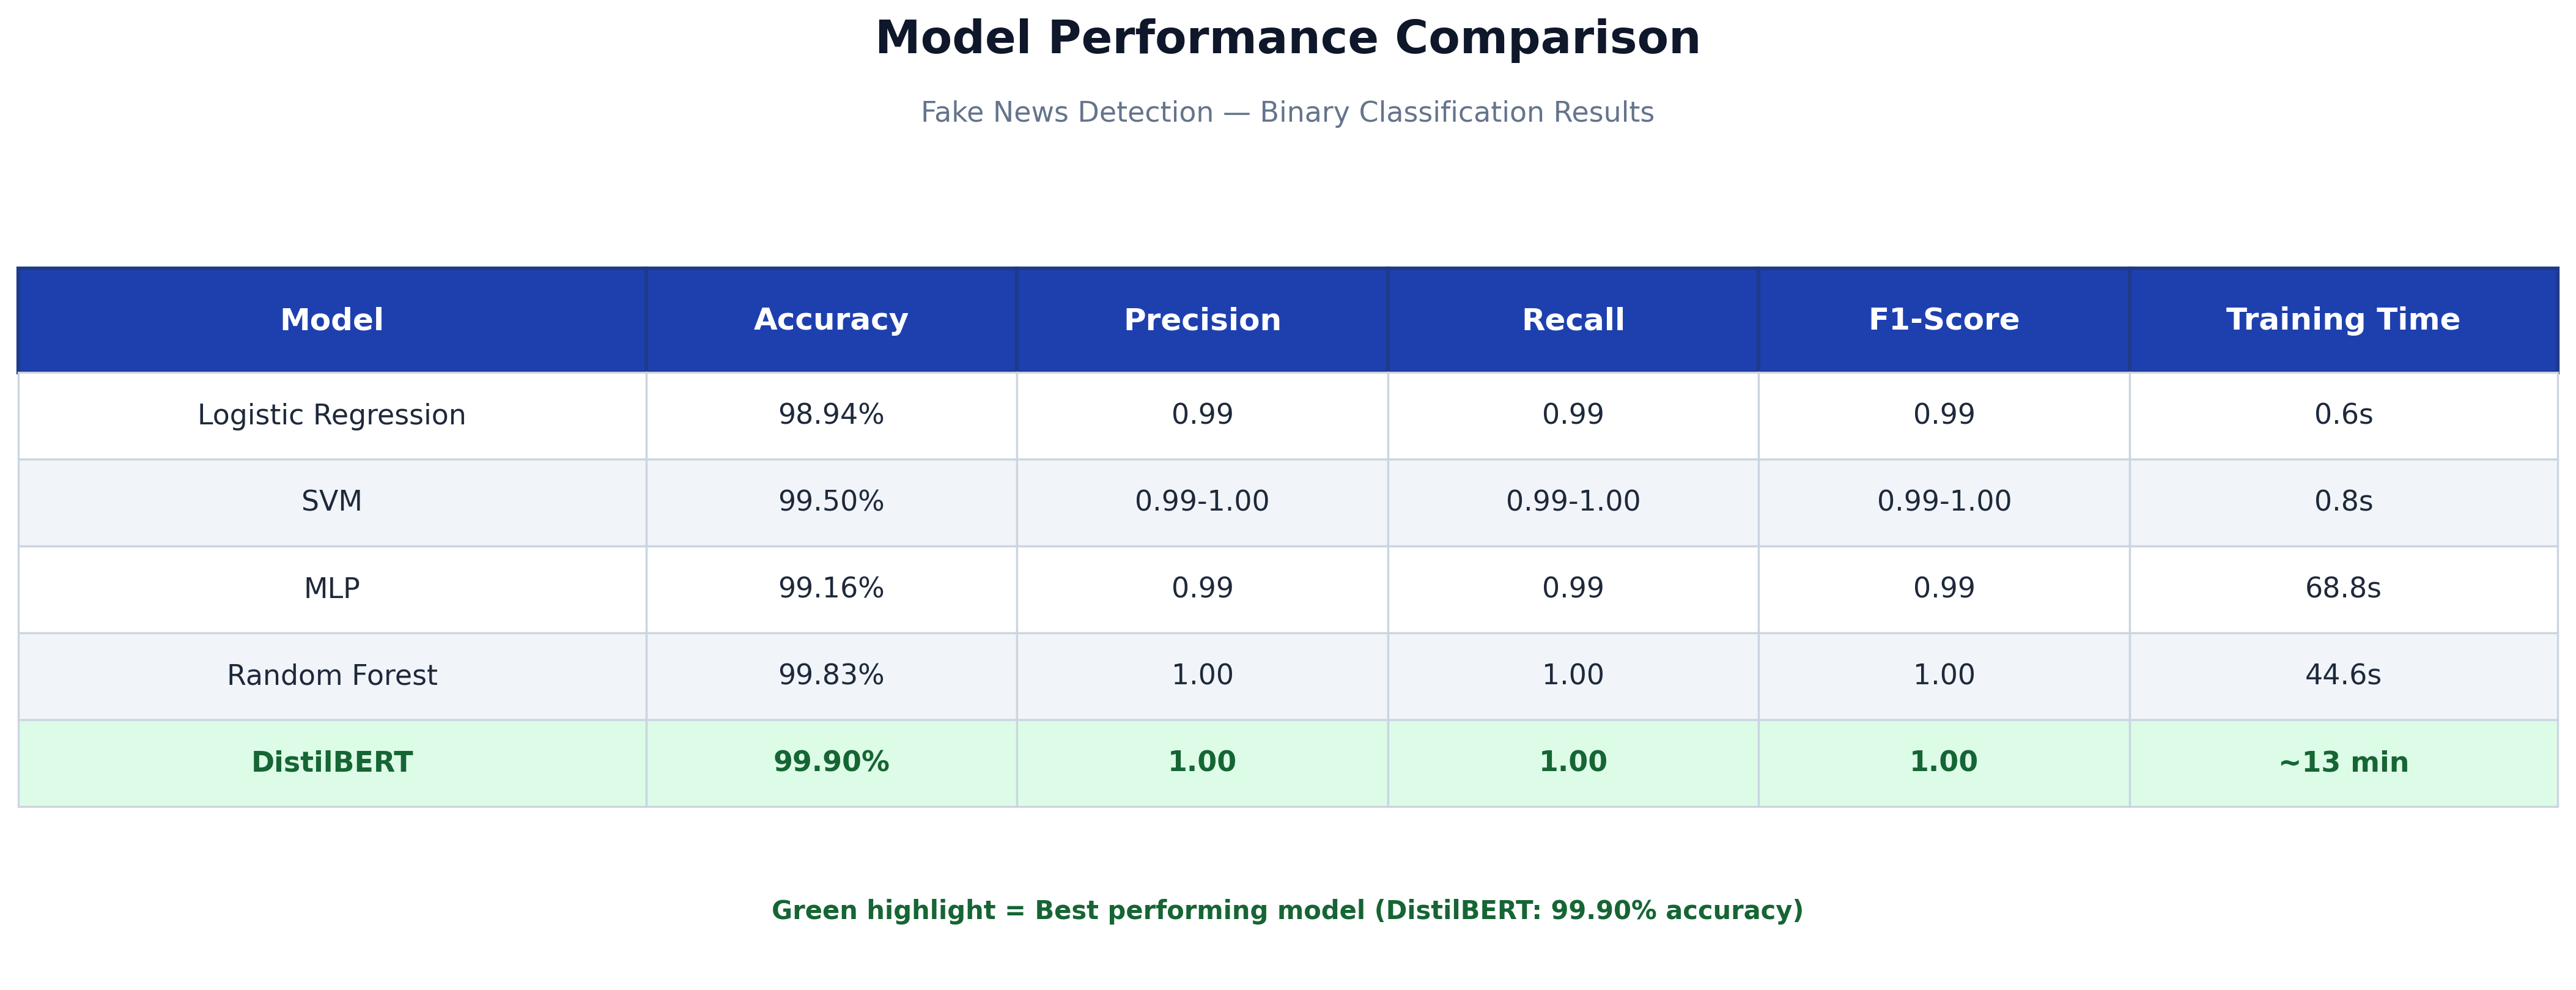

**Error Analysis:**

The Random Forest model made only 15 errors out of 8,980 test samples (0.17% error rate).

**Types of errors observed:**

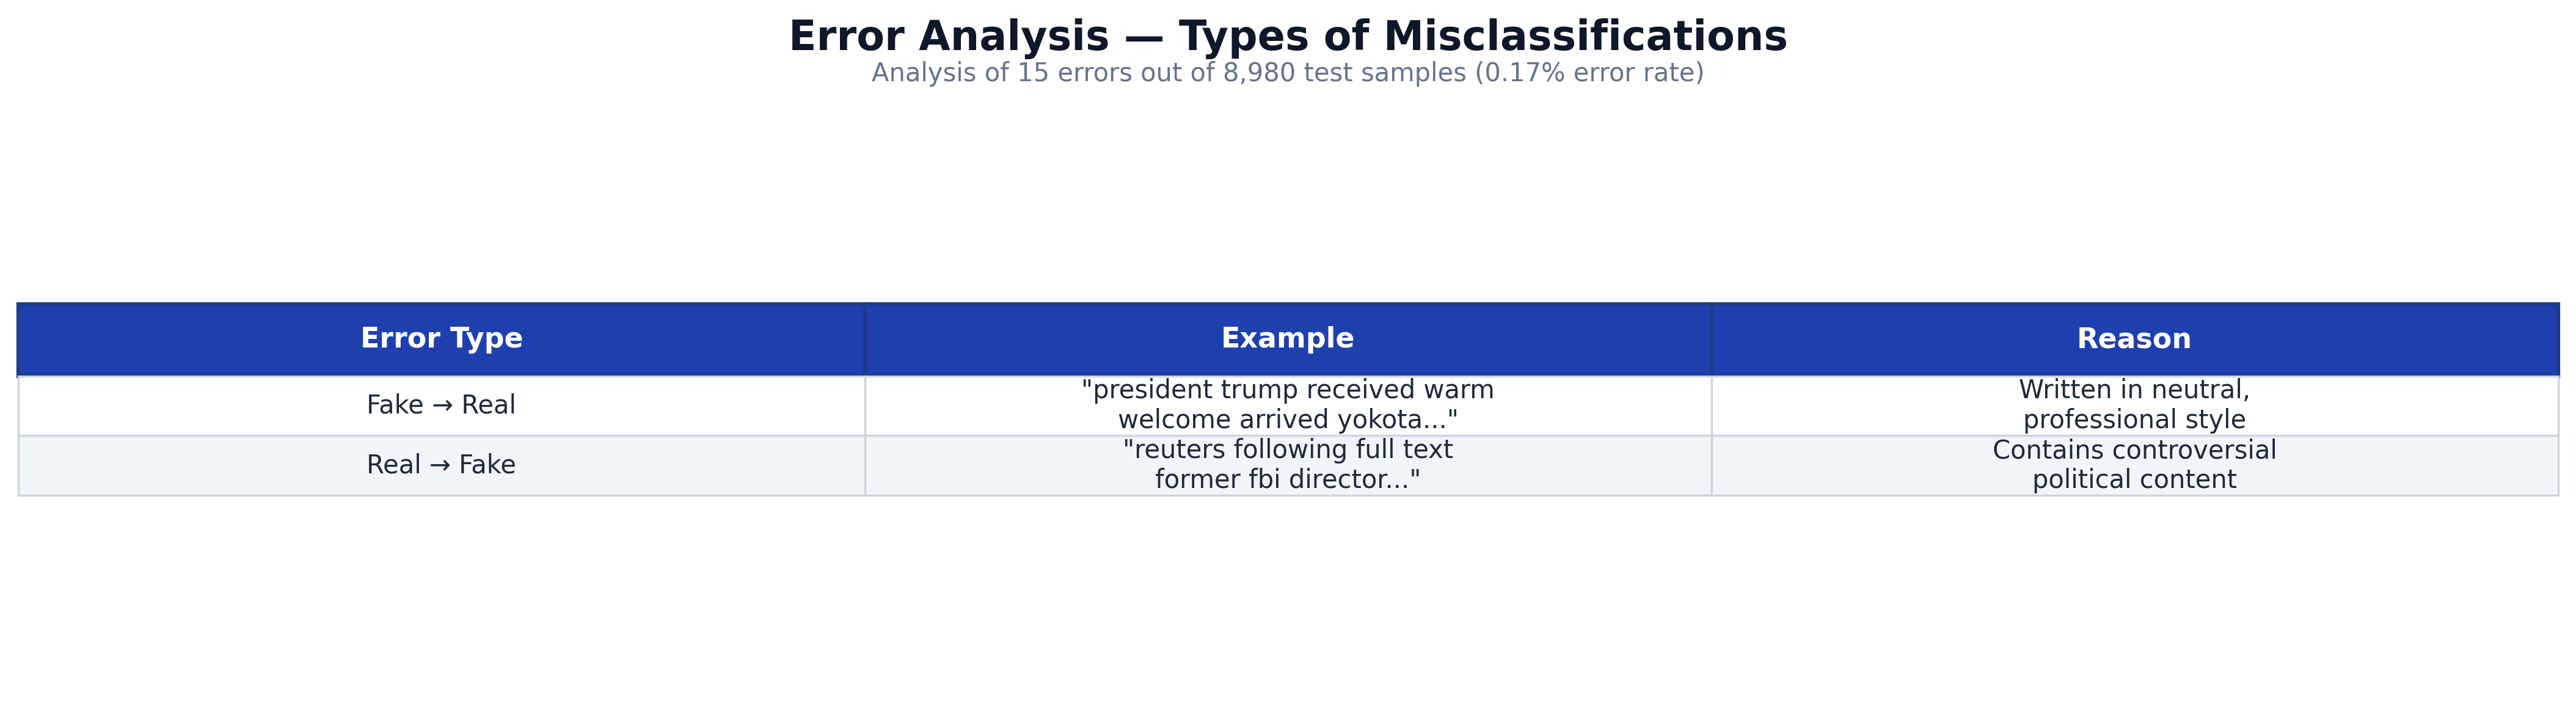

**Key Insight:** The model struggles when fake news mimics professional writing style, or when real news
covers sensational political topics. This is because the model detects writing style patterns, not factual
accuracy.

**Live Testing Results:**
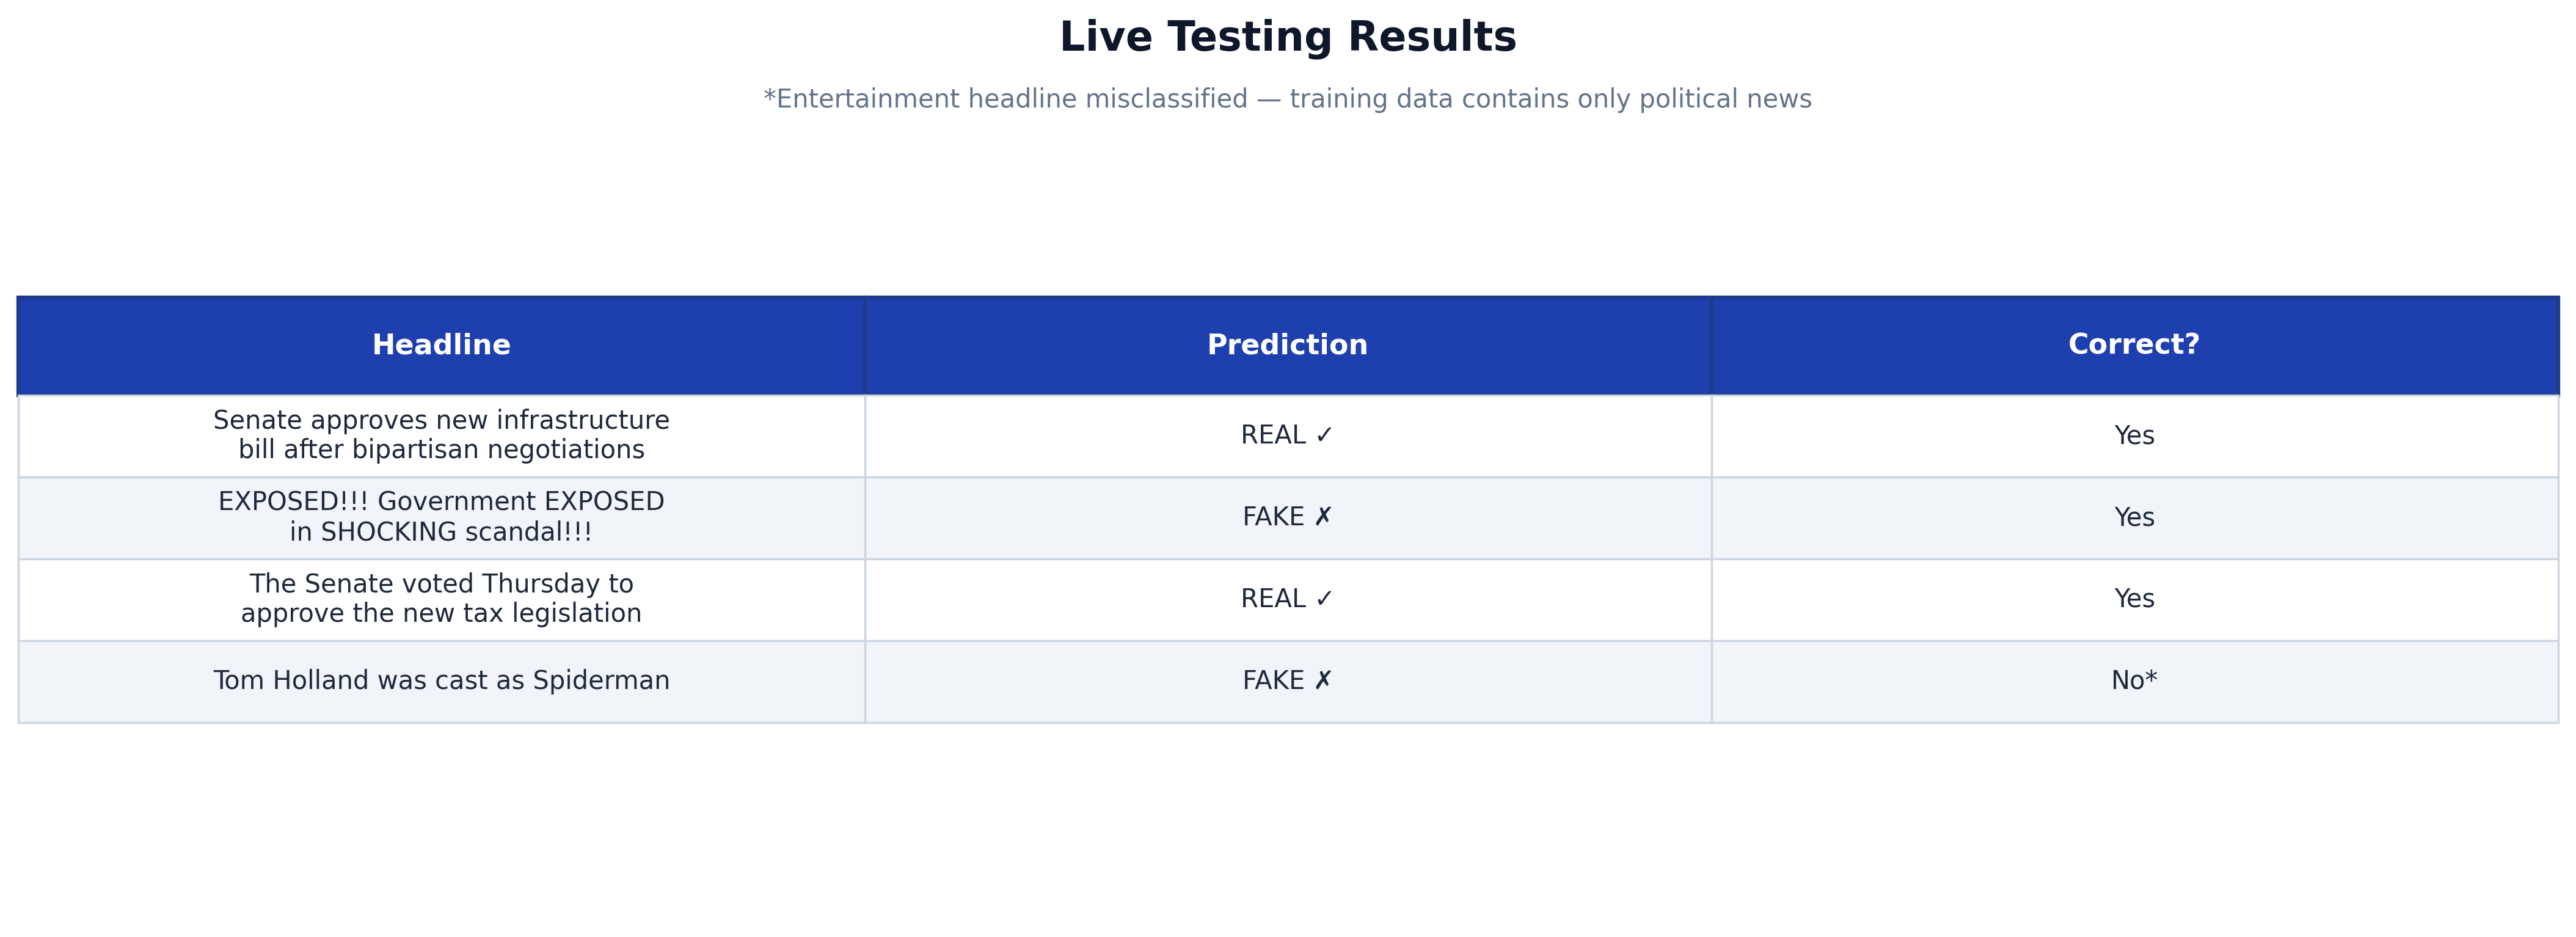

*The entertainment headline was misclassified because the training data contains only political news. This
demonstrates a domain limitation.

**D.3 Interpretation and Insights**

**Key Findings:**

1. **All models achieved >98% accuracy,** indicating that fake and real news have distinguishable textual patterns in this dataset.
2. **DistilBERT achieved the highest accuracy (99.90%)** but required significantly more training time
(~13 minutes)
3. **Speed vs Accuracy Trade-off:** For real-time applications requiring fast inference, use Logistic
Regression or SVM. For highest accuracy when time is not critical, use DistilBERT.
4. **The model detects writing style, not facts.** Clickbait language, excessive punctuation, and
sensationalist vocabulary are strong indicators of fake news.
5. **Word cloud analysis** revealed that fake news frequently contains words like 'trump,' 'clinton,'
'corrupt,' while real news contains more neutral reporting language.

**Limitations:**

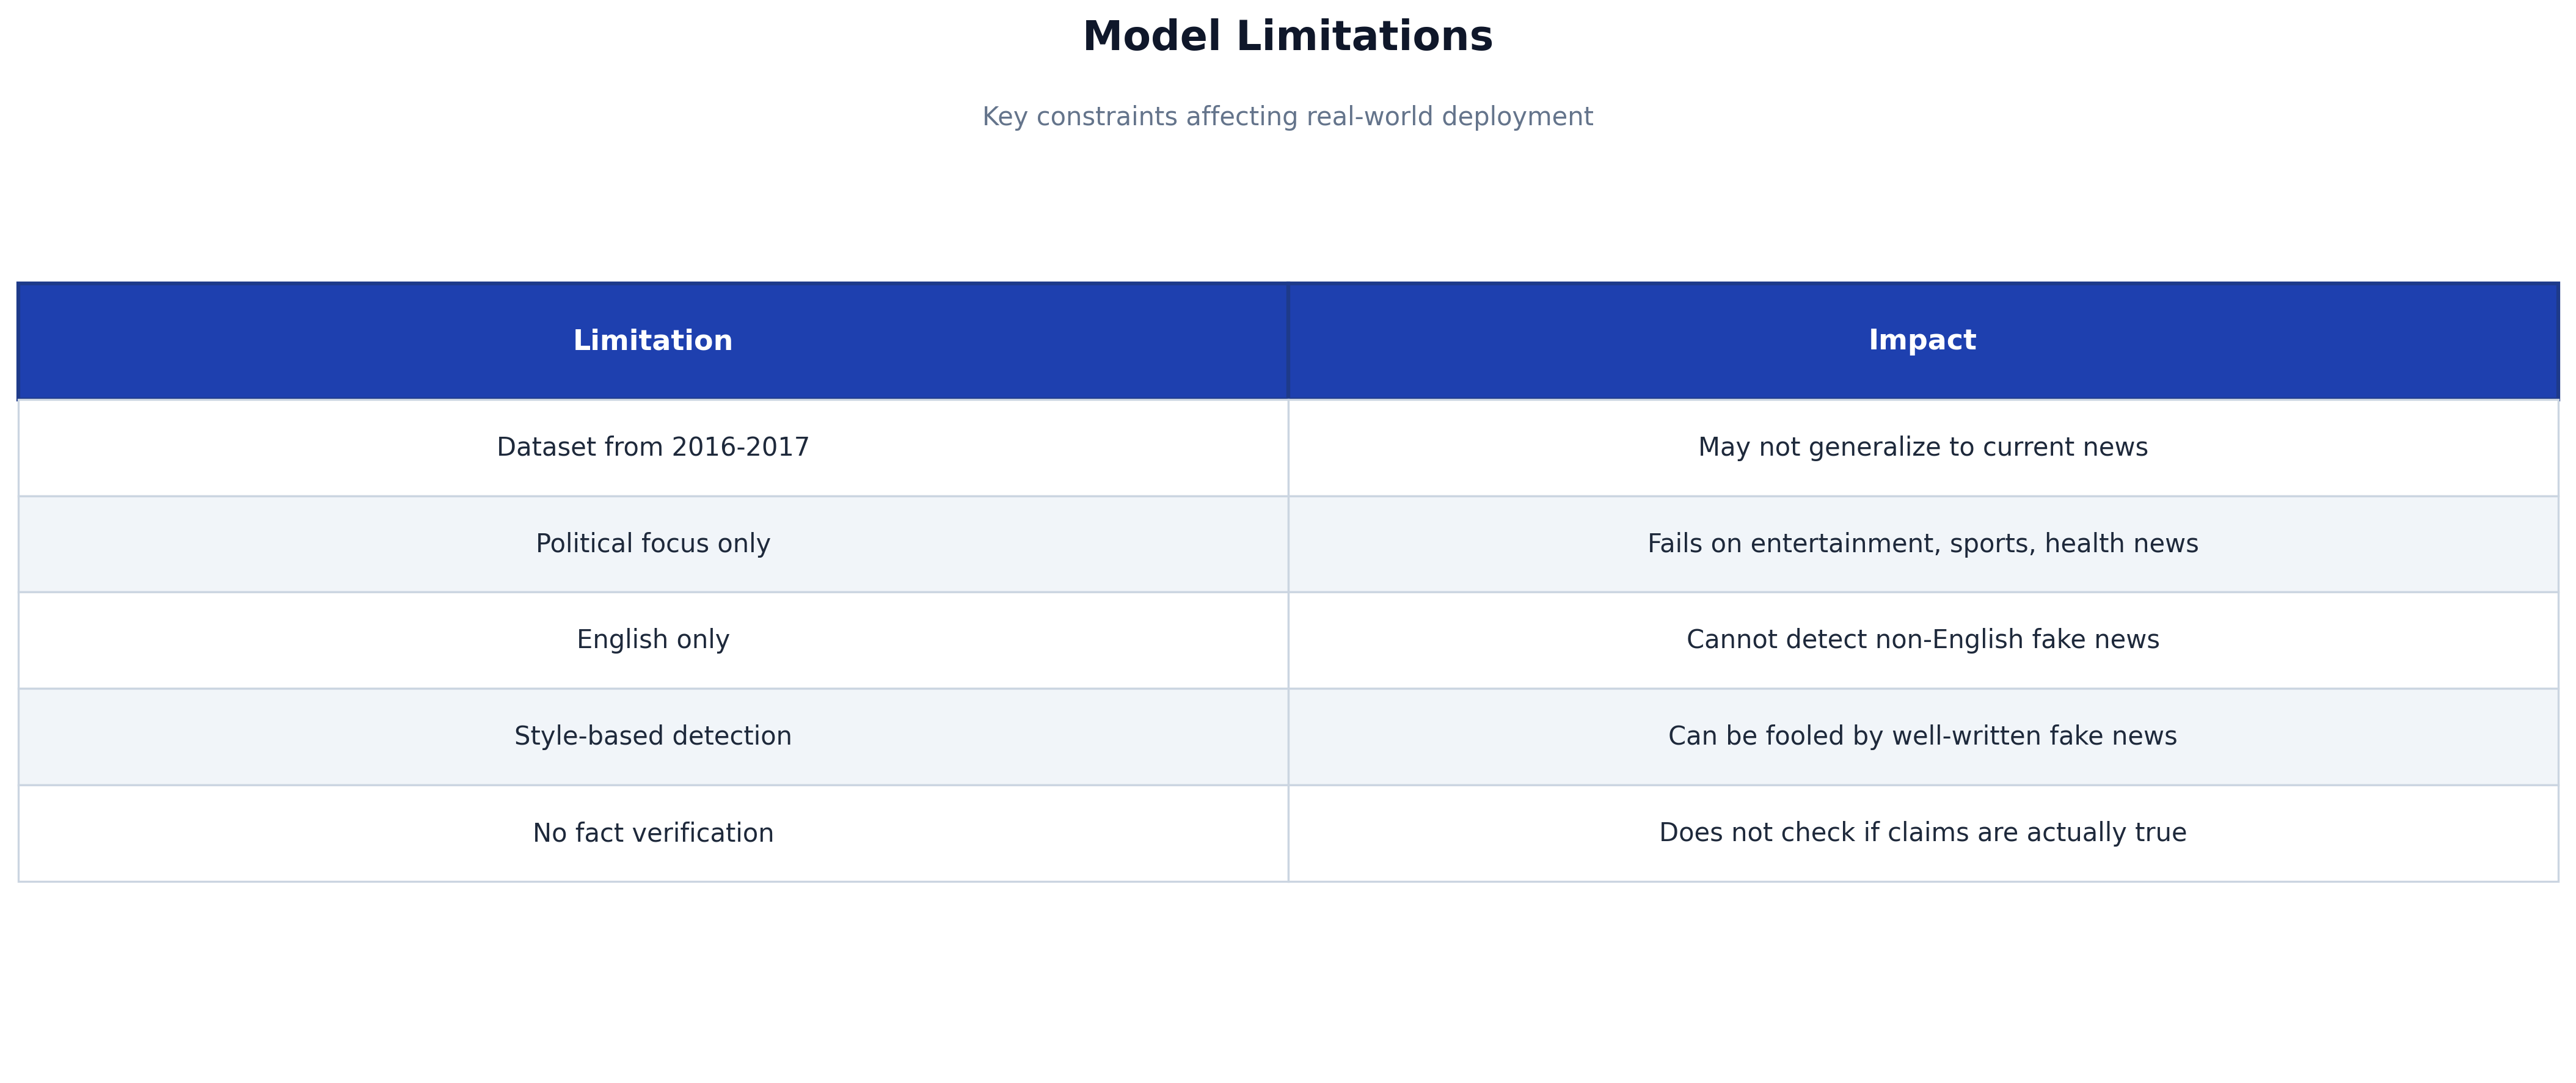

**Recommendations for Improvement:**

1. Train on more recent, diverse datasets
2. Combine text analysis with source credibility checking
3. Implement fact-verification using knowledge bases
4. Add multilingual support
5. Regular retraining to adapt to evolving fake news patterns

# PART E - Equity, Diversity, Inclusion (EDI) and Sustainability

**Bias and Fairness:**

**Dataset Bias:** The training dataset is predominantly US political news from 2016-2017. This introduces
several biases:

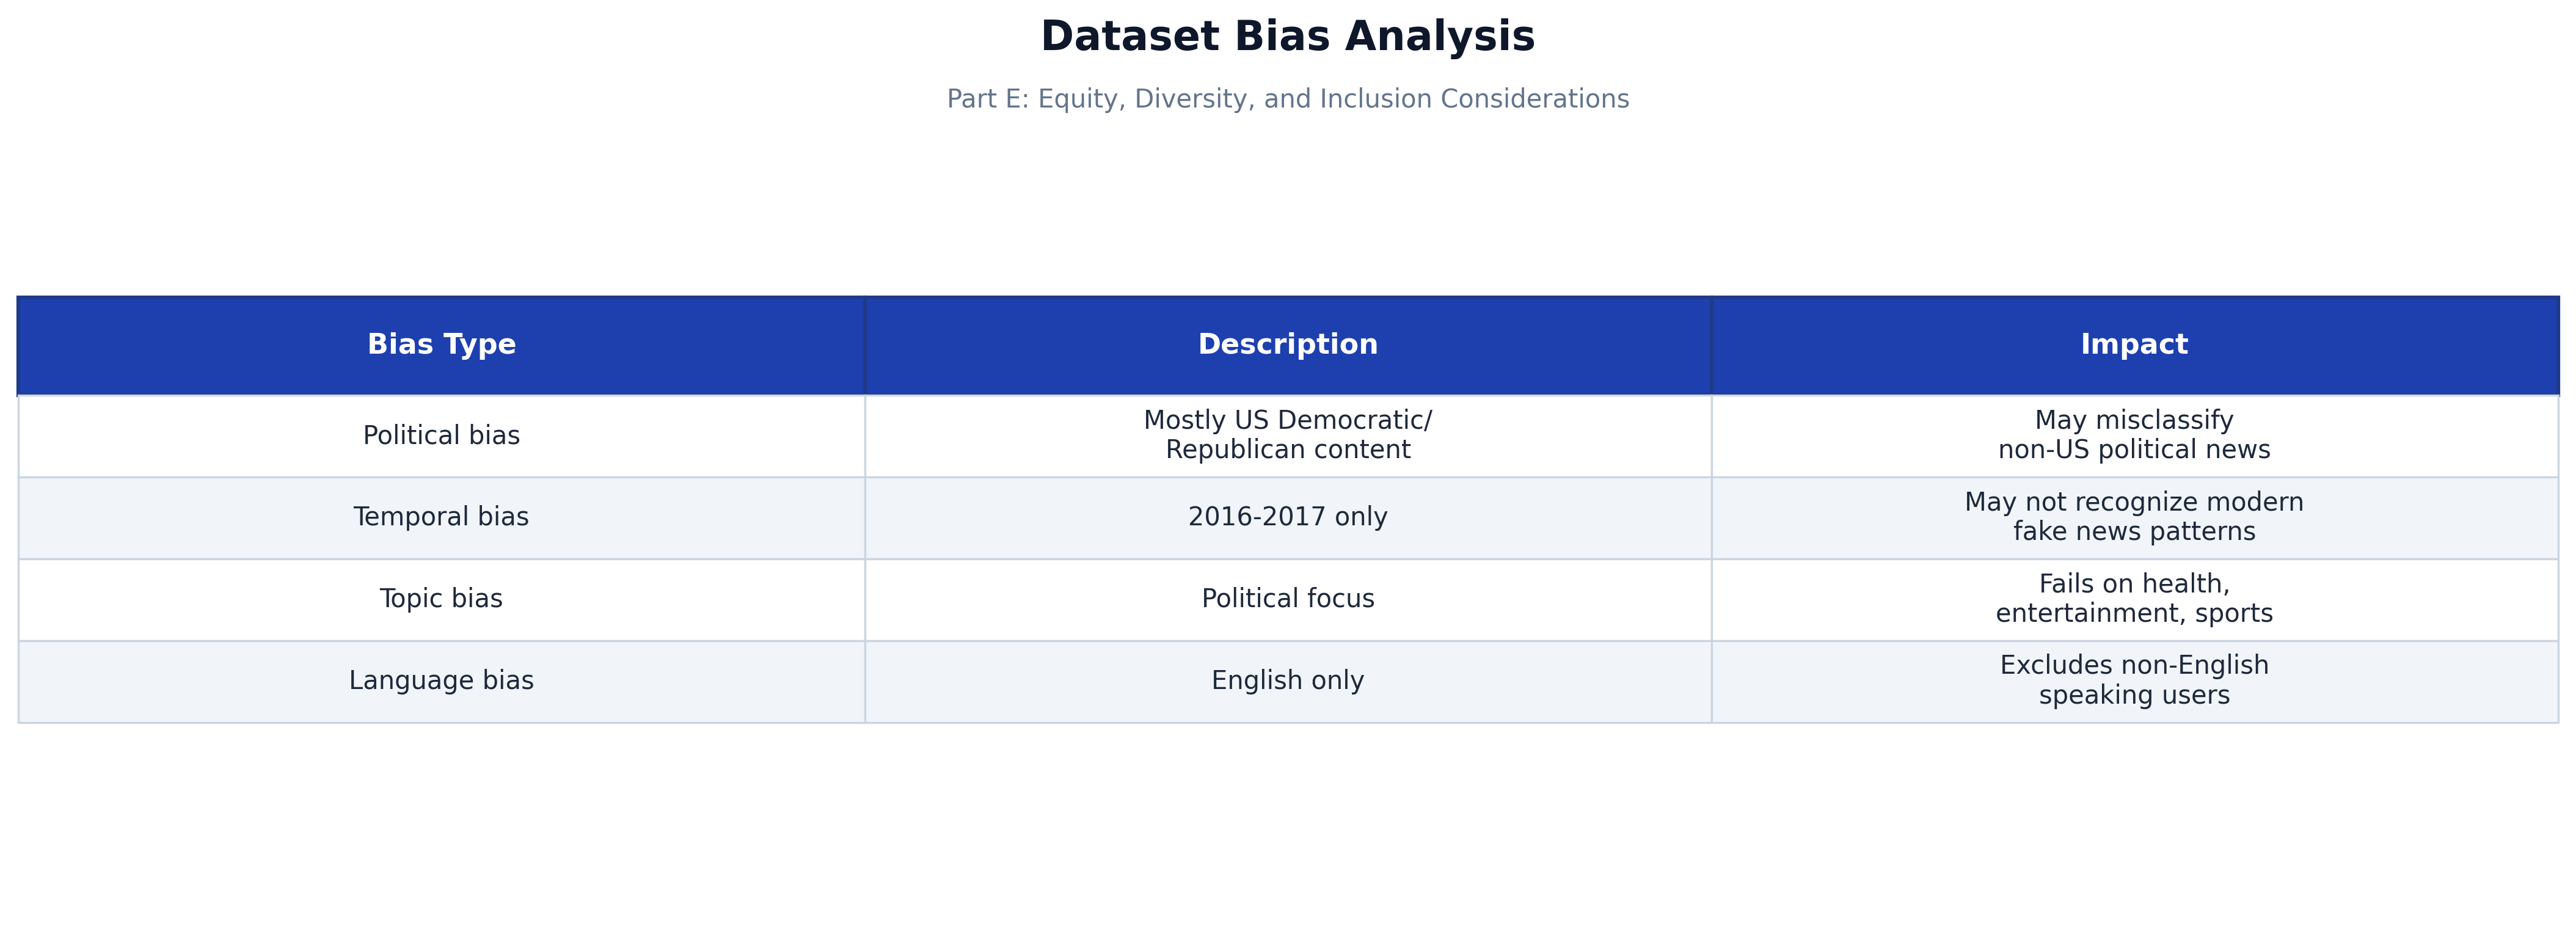

**Potential for Harm:**

• False positives could censor legitimate news
• False negatives could allow harmful misinformation to spread
• Political bias could disproportionately flag certain viewpoints

**Mitigation Strategies:**

• Use diverse, balanced training datasets
• Regular auditing for bias across political spectrums
• review for borderline cases
• Transparency about model limitations

**Accessibility and Inclusion:**
**Positive Impacts:**

• Automated detection helps users with limited media literacy identify potential misinformation
• Can be integrated into accessibility tools (screen readers, browser extensions)
• Reduces cognitive load of manual fact-checking
• Democratizes access to fact-checking tools

**Ethical Implications:**

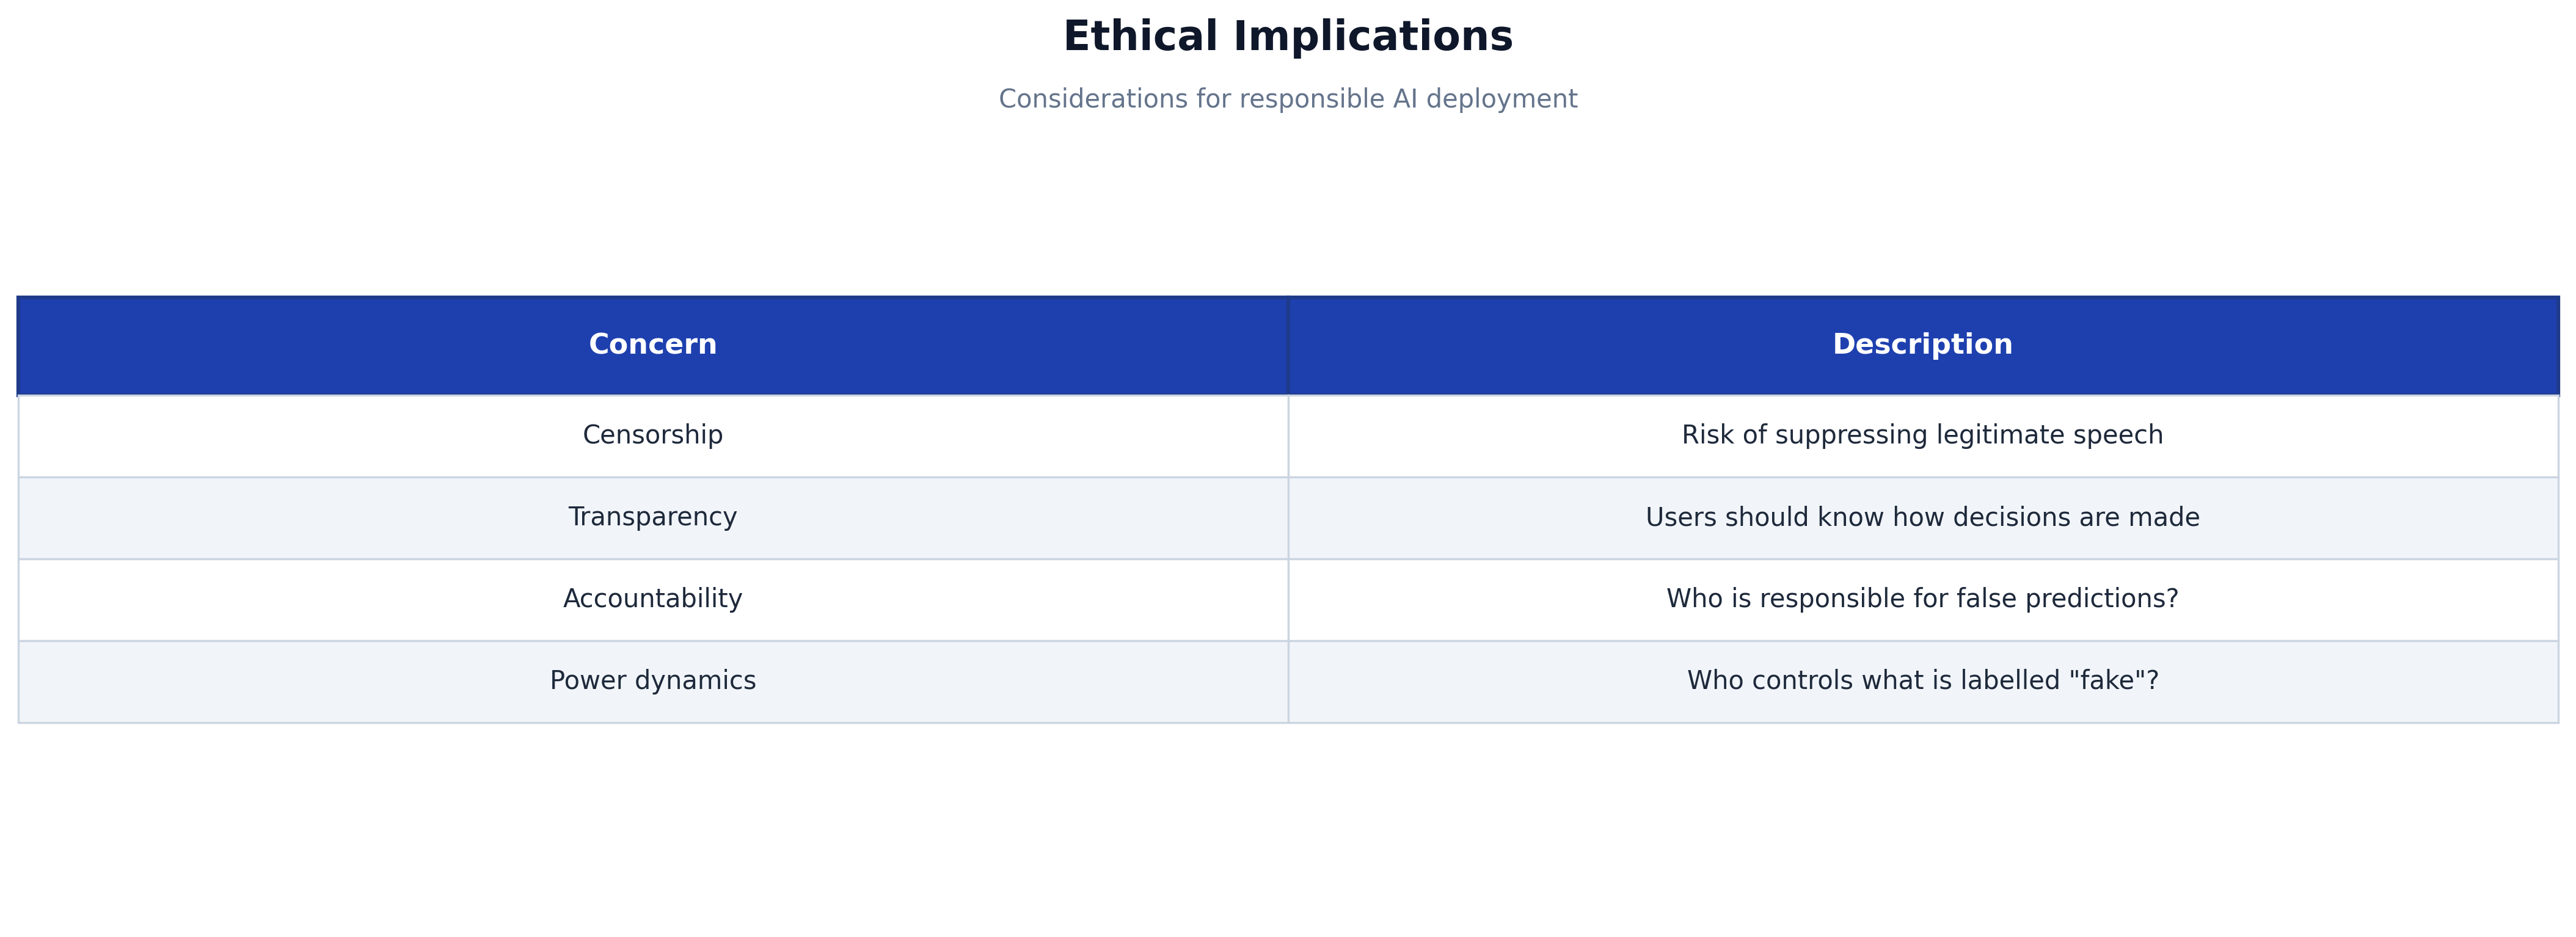

**Ethical Recommendations:**

1. Use as an advisory tool, not automatic censorship
2. Provide explanations for predictions
3. Allow appeals/human review
4. Regular third-party audits
5. Open-source model for public scrutiny

**E.2 Environmental Sustainability**

**Computational Resource Analysis:**

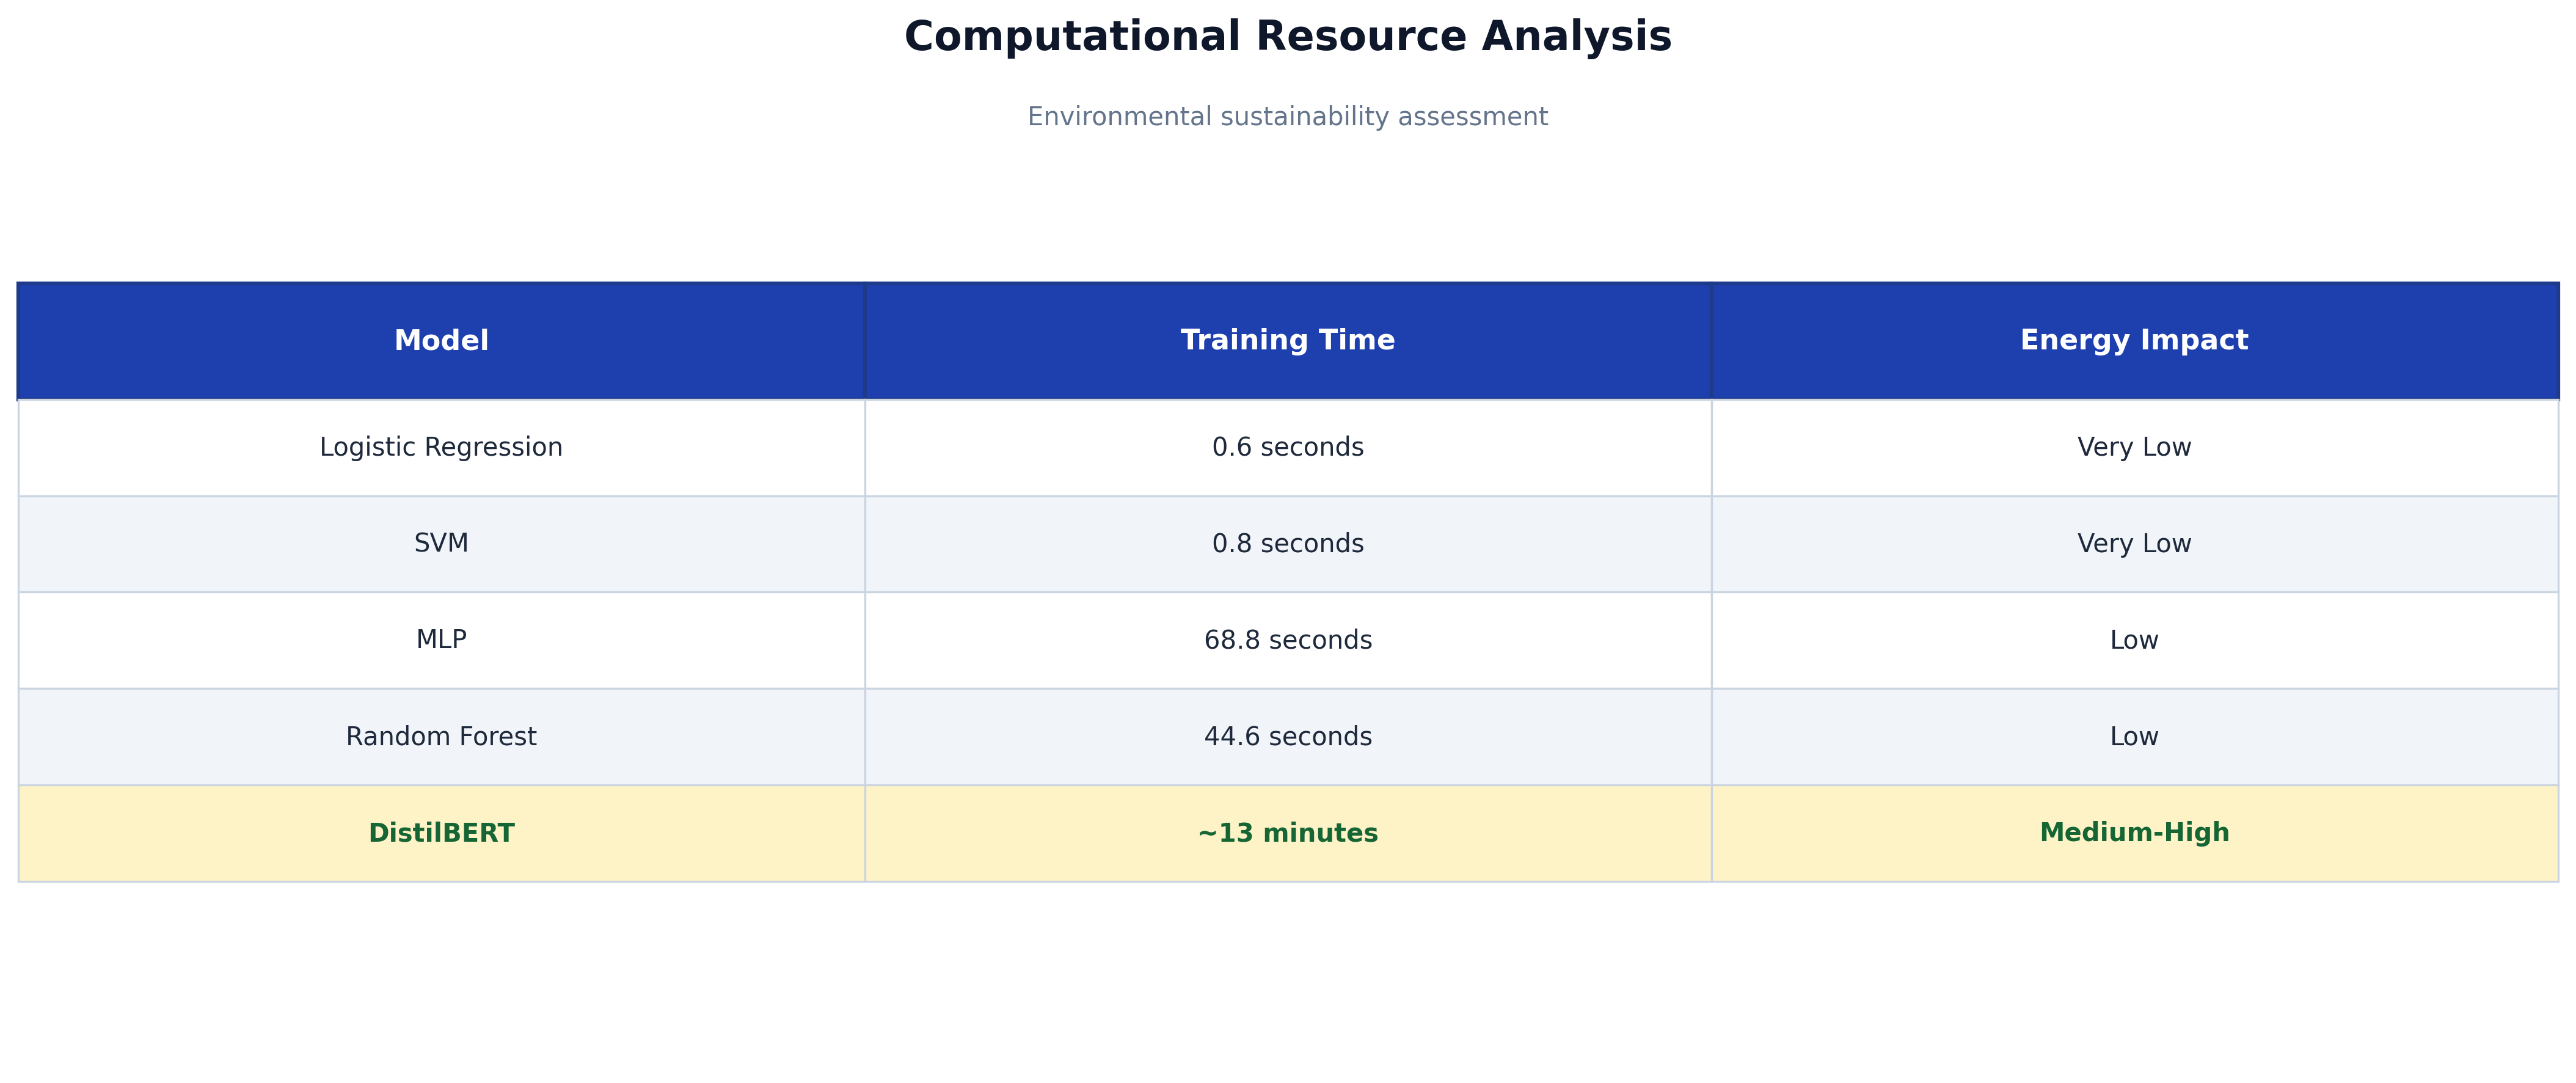

**DistilBERT Considerations:**

• Requires GPU for efficient training
• Pre-trained model download: ~250MB
• Fine-tuning uses significant energy
• However, DistilBERT is already 60% smaller than BERT, reducing environmental impact

**Data Storage Requirements:**

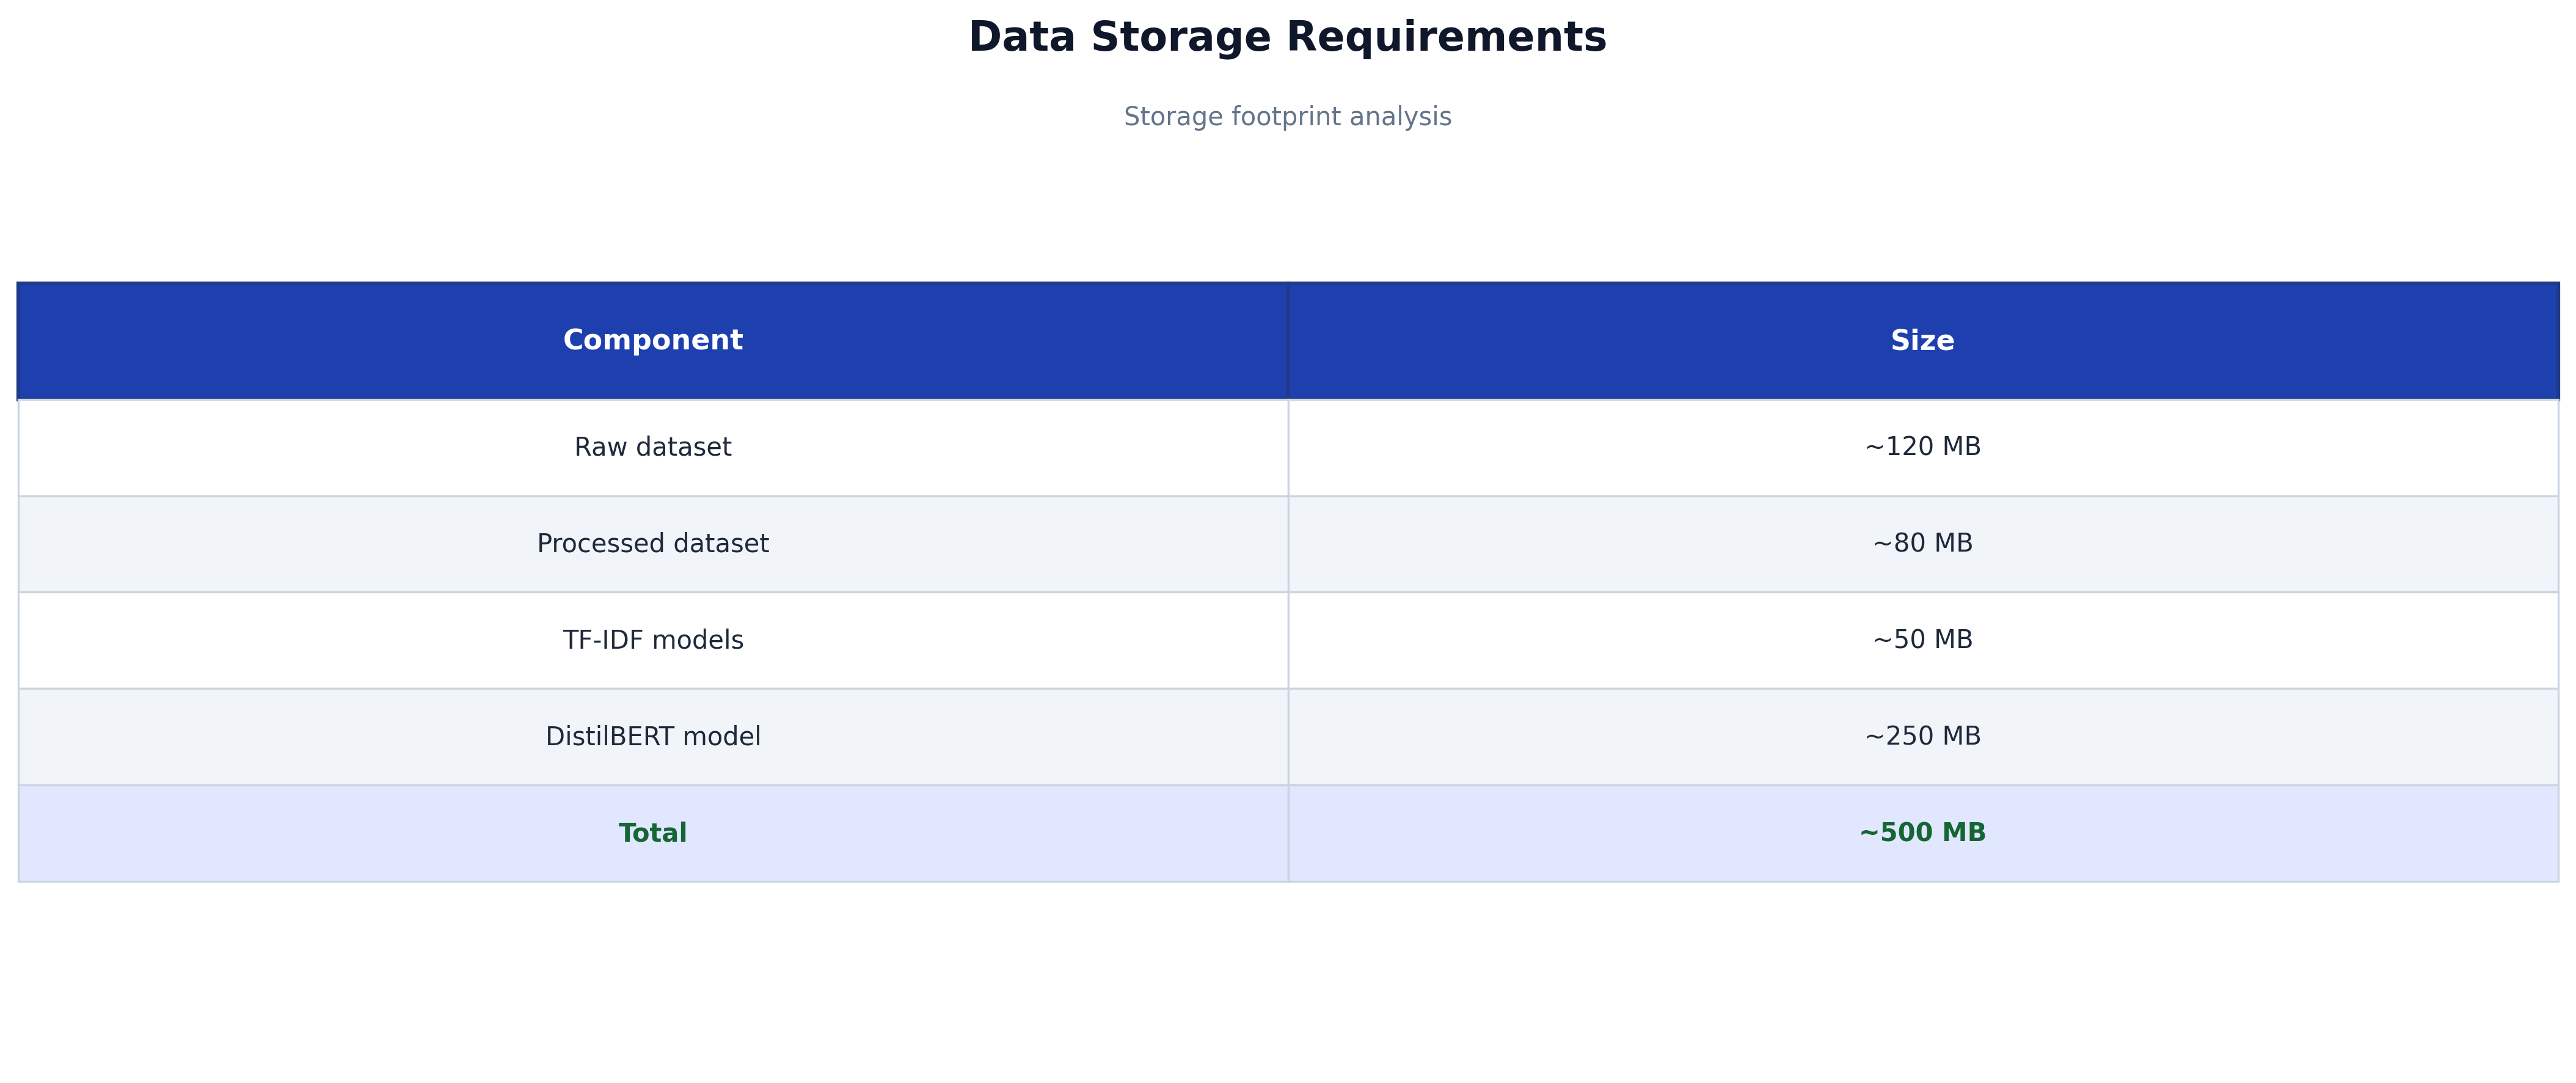

**Carbon Footprint Estimation:**

Training the DistilBERT model for 13 minutes on a T4 GPU consumes approximately:

• Power consumption: ~70W
• Energy used: ~0.015 kWh
• CO2 equivalent: ~7g (assuming average grid carbon intensity)
For comparison, a single Google search produces ~0.2g of CO2.

**Strategies for Reducing Environmental Impact:**

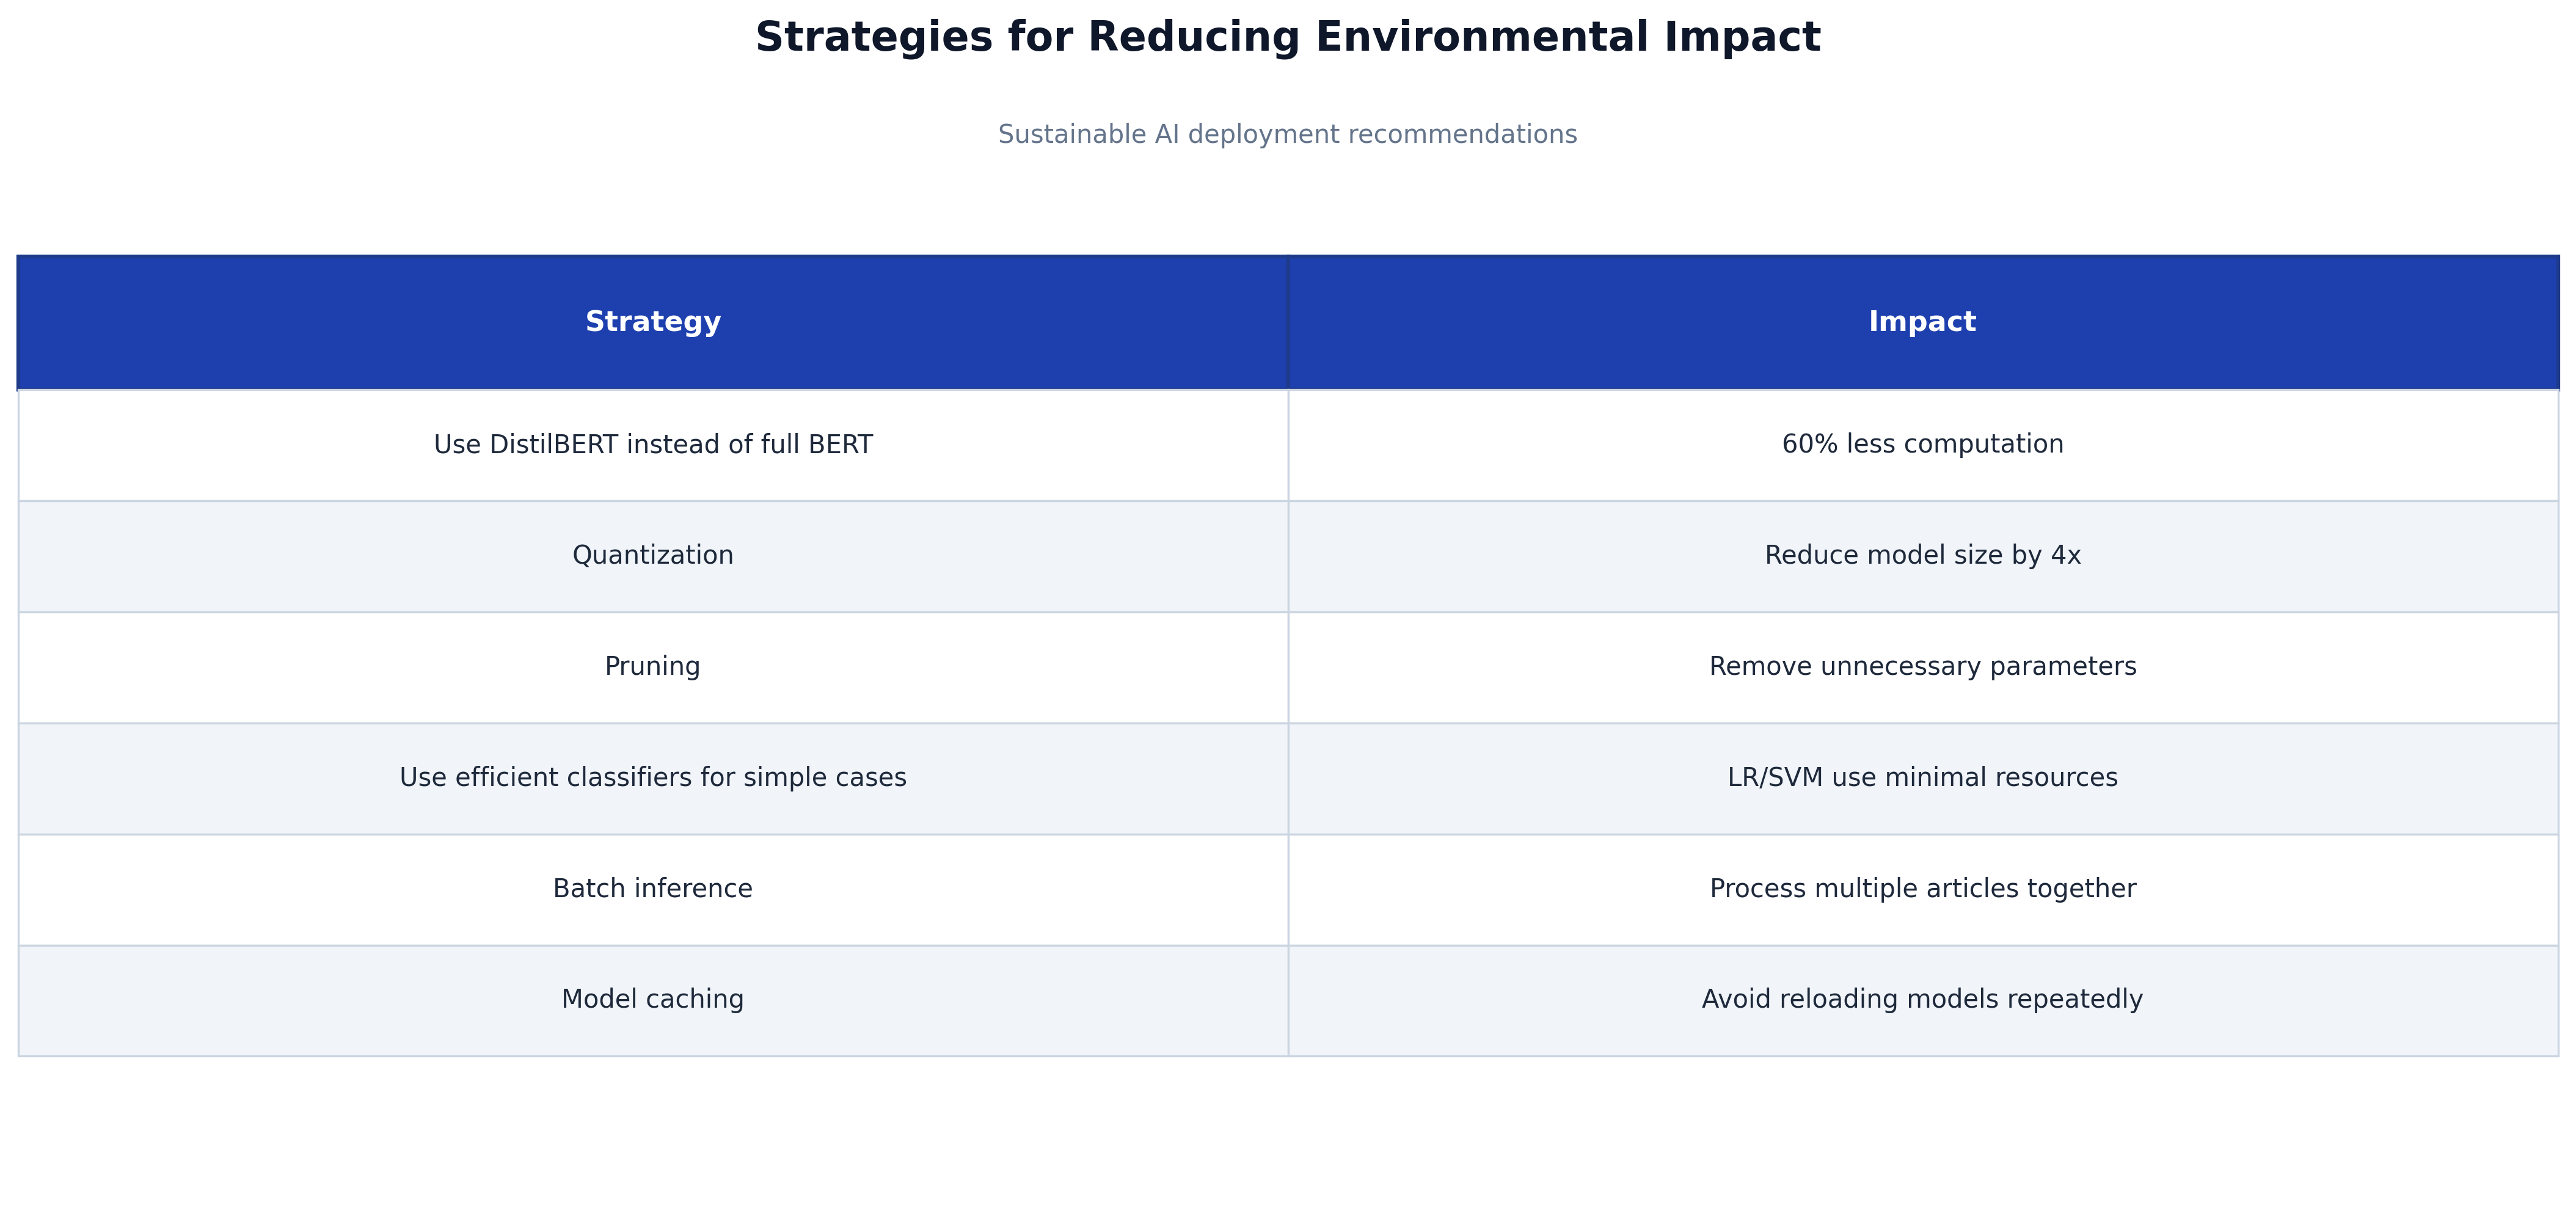

**Production Deployment Recommendations:**

1. Tiered approach: Use fast Logistic Regression for initial screening, BERT only for uncertain cases
2. Edge deployment: Run models on user devices to reduce server load
3. Model distillation: Create smaller student models from BERT
4. Green hosting: Use cloud providers with renewable energy
5. Efficient inference: Use ONNX runtime for faster predictions


